[View in Colaboratory](https://colab.research.google.com/github/dh-g3/desafio2/blob/master/02_Prediccion.ipynb)

# INTRODUCCIÓN

El presente desafío consiste en trabajar sobre los datos ya analizados previamente del sitio de Properati. El objetivo principal es elaborar un predictor de precios mediante la implementación de modelos de regresión lineal incluidos en la librería de sci-kit de python.


Si bien no se volverá a trabajar sobre el análisis exploratorio de datos o imputación de valores, se incluye el dataset completo en su formato original a fin de facilitar ciertas revisiones en las tareas de limpieza realizadas. Ésto será includo en una primera parte (A).


Seguidamente, se prepararán los datos para ser procesados y se procederá al entrenamiento de los modelos, selección del mejor y validación con una muestra de prueba.


Por último, se implementará el modelo elegido para un ejercicio de optimización sobre una fracción del dataset (y eventualmente el dataset completo). El fin será determinar qué operaciones se deberían hacer (venta/compra) para maximizar el beneficio.

# A. LIMPIEZA DE DATOS


## 0.Instalación de GDrive

**Los archivos se encuentran alojados en Google Drive, para lo cual se ejecutan los siguientes comandos a fin de importarlos a la notebook**

In [0]:
#Se instala para cada sesión
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Autentica y el crea el cliente Py
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Obtengo el contenido del archivo
json_import = drive.CreateFile({'id':'1yPeXRdcYoz8y56VF2BcP9FKA5Ws8LeXX'}) #El ID único del archivo en cuestión
json_import.GetContentFile('properati.csv')

**Se verifica que los archivos hayan sido correctamente cargados**

In [3]:
from google.colab import files
#files.os.listdir()
'properati.csv' in files.os.listdir()


True

## 1.Importación de librerías y archivos de datos


 **Se importan las librerías  a utilizar:**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


**Se importan los archivos a emplear y se visualizan los encabezados junto con sus primeras filas**

In [5]:
df = pd.read_csv("properati.csv",encoding = 'UTF-8')
df.head()


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


## 2.Limpieza de datos

###2.a) Operaciones iniciales (indicadores de missing values y limpieza de caracteres)

**Columnas indicadoras de nulos iniciales**

Se crean columnas auxiliares con 0 y 1 según valores nulos iniciales. En principio, es solo a modo de control y sin un objetivo concreto

In [0]:
def indicar_nulos(DataFrame,lista):
   for col in lista:
      DataFrame[str(col)+'-null']=DataFrame[str(col)].isnull()

lst= ['operation', 'property_type', 'place_name','place_with_parent_names', 'country_name',
      'state_name', 'geonames_id','lat-lon', 'lat', 'lon', 'price', 'currency',
      'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2','surface_covered_in_m2',
      'price_usd_per_m2', 'price_per_m2', 'floor','rooms', 'expenses']

indicar_nulos(df,lst)

Se verifica la creación de las columnas indicadoras de nulos

In [7]:
df.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail', 'operation-null', 'property_type-null',
       'place_name-null', 'place_with_parent_names-null', 'country_name-null',
       'state_name-null', 'geonames_id-null', 'lat-lon-null', 'lat-null',
       'lon-null', 'price-null', 'currency-null',
       'price_aprox_local_currency-null', 'price_aprox_usd-null',
       'surface_total_in_m2-null', 'surface_covered_in_m2-null',
       'price_usd_per_m2-null', 'price_per_m2-null', 'floor-null',
       'rooms-null', 'expenses-null'],
      dtype='object')

**Definición de funciones para extraer expresiones regulares**

Se crean dos funciones para extraer expresiones regulares. Una que devuelve el crudo de expresiones extraidas y otra que muestra las palabras agrupadas y ordenadas por frecuencia/repetición.

In [0]:
### Link para probar expresiones regulares
### https://regexr.com/
### https://regex101.com/

def extraer_ER_crudo(DataFrame,campoDF,exp_reg,grupo_er=0):  
    #Input: DataFrame, Campo del dataframe a analizar, expresión regular considerada y nº de grupo de la exp regular
    #Output: Expresión regular encontrada
    df1=DataFrame.loc[:,campoDF].str.lower().str.extract(exp_reg,expand=True)
    return df1
  
def extraer_ER_groupby(DataFrame,campoDF,exp_reg,grupo_er=0):
    #Input: DataFrame, Campo del dataframe a analizar, expresión regular considerada y nº de grupo de la exp regular
    #Output: Groupby con la cantidad para cada expresión regular encontrada
    df1=DataFrame.loc[:,campoDF].str.lower().str.extract(exp_reg,expand=True)
    return df1.groupby(grupo_er)[[grupo_er]].count().sort_values(by=grupo_er,ascending = False)

**Creación de columnas descriptivas con los caracteres limpios**

Con el objetivo de limpiar los campos de texto se busca:
  * Pasar las palabras a minúsculas
  * Reemplazar todo tipo de símbolo por un espacio como separador
  * Eliminar los acentos de las vocales

In [0]:
def reemplazar_ch(texto):
  #Input: texto ingresado crudo
  #Output: texto sin mayusculas, separado por signos y sin sginos de acentuación
  separadores=',.:;/\_-()!¡?¿%#@"[]{}+~|ºªº*$'
  s=str(texto).lower()
  for ch in separadores:
    s=s.replace(ch,' ')
  s=s.replace('á','a').replace('à','a').replace('ä','a').replace('â','a')
  s=s.replace('é','e').replace('è','e').replace('ë','e').replace('ê','e')
  s=s.replace('í','i').replace('ì','i').replace('î','i').replace('î','i')
  s=s.replace('ó','o').replace('ò','o').replace('ö','o').replace('ô','o')
  s=s.replace('ú','u').replace('ù','u').replace('ü','u').replace('û','u')
  return s

La función anterior se aplica a cada uno de los campos y se crea uno auxiliar que los contiene a todos

In [0]:
df['c_description']=df['description'].apply(lambda x: reemplazar_ch(x))
df['c_title']=df['title'].apply(lambda x: reemplazar_ch(x))
df['aux']=extraer_ER_crudo(df,'properati_url','http://www.properati.com.ar/.{5}_[a-z]+_(\S.+)')
df['c_properati_url']=df['aux'].apply(lambda x: reemplazar_ch(x))
del df['aux']
df['c_desc_title_url']= df['c_description']+ ' / ' + df['c_title'] + ' / ' + df['c_properati_url']

Muestra de los resultados obtenidos

In [11]:
df['c_description'].head()

0    2 ambientes tipo casa planta baja por pasillo ...
1    venta de departamento en decimo piso al frente...
2    2 ambientes 3er piso lateral living comedor am...
3    ph 3 ambientes con patio  hay 3 deptos en lote...
4    departamento con fantastica iluminacion natura...
Name: c_description, dtype: object

In [12]:
df['c_title'].head()

0                   2 amb tipo casa sin expensas en pb
1    venta depto 2 dorm  a estrenar 7 e  36 y 37   ...
2             2 amb 3er piso con ascensor apto credito
3                         ph 3 amb  cfte  reciclado   
4    depto 2 amb al contrafrente zona centro plaza ...
Name: c_title, dtype: object

In [13]:
df['c_properati_url'].head()

0      ph mataderos lavadero patio inmobiliaria fedele
1    departamentos la plata balcon lavadero toilett...
2    departamentos mataderos lavadero placard inmob...
3                          ph liniers patio g goffredo
4    departamentos centro cristina pavone negocios ...
Name: c_properati_url, dtype: object

In [14]:
df['c_desc_title_url'].head()

0    2 ambientes tipo casa planta baja por pasillo ...
1    venta de departamento en decimo piso al frente...
2    2 ambientes 3er piso lateral living comedor am...
3    ph 3 ambientes con patio  hay 3 deptos en lote...
4    departamento con fantastica iluminacion natura...
Name: c_desc_title_url, dtype: object

### 2.b) Análisis de las relaciones de las columnas de precios, superficies y precios por m²






Se estima la cotización del dolar a la fecha de publicación de los anuncios, según la conversión realizada (cociente entre el precio en moneda local y el precio publicado):

In [15]:
(df['price_aprox_local_currency'] / df['price']).value_counts().head()

17.644500    82401
0.989568       714
17.644500      668
0.989568       229
0.989568       224
dtype: int64

Se concluye que la cotizacion del dolar a la fecha era 17.64 y se lo asigna a una variable.

In [0]:
cotizacion_usd=17.6445

Al analizar las columnas vinculadas al precio, superficie y valor por m² se tienen los siguientes campos:
* price
* currency
* price_aprox_usd
* surface_total_in_m2
* surface_covered_in_m2
* price_usd_per_m2
* price_per_m2

In [17]:
df[:][['price','currency','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2','price_per_m2']].head(10)

,price,currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2
0,62000.0,USD,62000.00,55.0,40.0,1127.272727,1550.000000
1,150000.0,USD,150000.00,NaN,NaN,NaN,NaN
2,72000.0,USD,72000.00,55.0,55.0,1309.090909,1309.090909
3,95000.0,USD,95000.00,NaN,NaN,NaN,NaN
4,64000.0,USD,64000.00,35.0,35.0,1828.571429,1828.571429
5,NaN,NaN,NaN,53.0,NaN,NaN,NaN
6,130000.0,USD,130000.00,106.0,78.0,1226.415094,1666.666667
7,138000.0,USD,138000.00,45.0,40.0,3066.666667,3450.000000
8,195000.0,USD,195000.00,65.0,60.0,3000.000000,3250.000000
9,460000.0,ARS,25798.49,NaN,NaN,NaN,NaN


In [18]:
#Valores sin precio o valor de superficie
b1 = ~df['price'].isna()
b2 = ~(df['surface_total_in_m2'].isna() | (df['surface_total_in_m2']==0))
b3 = ~(df['surface_covered_in_m2'].isna() | (df['surface_covered_in_m2']==0))

print( sum(b1 & (b2 | b3)) )
del [b1, b2, b3]

92925


Posteriormente a un analisis, se establecieron las siguientes relaciones:

* price . currency = price_aprox_local_currency
* price . currency = price_aprox_usd
* price_usd_per_m2 = price_aprox_usd / surface_total_in_m2
* price_per_m2 = price / surface_covered_in_m2


Uno de los primeros aspectos que surge es la necesidad de recalcular un único valor de precio por m² que considere la superficie total y el precio en una única moneda equivalente. Para ello se crean las columnas finales (prefijo f_) de los valores asociados.

A continuación se inicializan las siguientes columnas:
* f_price: Precio de la propiedad según la publicación
* f_cambio: Coeficiente de cambio de moneda según corresponda (1 para USD, 17,64 para ARS)
* f_price_usd: Precio luego de aplicar una conversión de moneda
* f_stot: Superficie total de la propiedad
* f_scub: Superficie cubierta de la propiedad
* f_price_m2_usd: Precio en dólares del m²

In [0]:
df['f_price']=df['price']

df['f_currency']=df['currency']
df.loc[df['currency']=='USD','f_cambio']=1
df.loc[df['currency']=='ARS','f_cambio']=cotizacion_usd

df['f_price_usd']=df['price']*df['f_cambio']

df['f_stot']=df['surface_total_in_m2']
df['f_scub']=df['surface_covered_in_m2']

df['fil']=(df['surface_total_in_m2'].isna()) & (~df['surface_covered_in_m2'].isna())
df.loc[df['fil'],'f_stot']=df['f_scub']

df.loc[df['f_stot']==0,'f_stot']=np.nan
df.loc[df['f_price_usd']==0,'f_price_usd']=np.nan
df['f_price_m2_usd']=df['f_price_usd']/df['f_stot']

df.loc[(df['f_price_m2_usd']==np.Inf),'f_price_m2_usd']=np.NaN

#del df['fil']

In [20]:
sum(~df['f_price_m2_usd'].isna())

92925

In [0]:
#df['f_stot']=df['surface_total_in_m2']

In [22]:
df.loc[df['fil']][['surface_total_in_m2','surface_covered_in_m2','f_price_usd','f_stot','f_scub','f_price_usd','f_price_m2_usd']].head(10)

,surface_total_in_m2,surface_covered_in_m2,f_price_usd,f_stot,f_scub,f_price_usd,f_price_m2_usd
68,NaN,72.0,235000.0,72.0,72.0,235000.0,3263.888889
77,NaN,85.0,150000.0,85.0,85.0,150000.0,1764.705882
79,NaN,42.0,118000.0,42.0,42.0,118000.0,2809.523810
87,NaN,170.0,875000.0,170.0,170.0,875000.0,5147.058824
89,NaN,53.0,50000.0,53.0,53.0,50000.0,943.396226
92,NaN,73.0,120000.0,73.0,73.0,120000.0,1643.835616
93,NaN,416.0,385000.0,416.0,416.0,385000.0,925.480769
94,NaN,95.0,135000.0,95.0,95.0,135000.0,1421.052632
95,NaN,180.0,75000.0,180.0,180.0,75000.0,416.666667
109,NaN,60.0,55000.0,60.0,60.0,55000.0,916.666667


In [23]:
df['f_price_m2_usd'].describe()

count    9.292500e+04
mean     6.416640e+04
std      3.559953e+05
min      6.000000e-01
25%      1.357143e+03
50%      2.024390e+03
75%      3.007692e+03
max      7.057800e+07
Name: f_price_m2_usd, dtype: float64

### 2.c) Detección y exclusión de valores fuera de serie (outliers)

En las variables cuantitativas, se puede realizar la excusión de los valores outliers según ciertos parámetros estadísticos y criterios adoptados en base a ellos. En este caso se opta por excluir aquellos valores que se ubiquen fuera de cierto rango que considera los cuartiles q1, q3, el rango intercuartil (IQR) y un coeficiente a aplicarle al mismo (habitualmente se considera 1.5 tal como se indica en la figura).

![texto alternativo](https://www.whatissixsigma.net/wp-content/uploads/2015/07/Box-Plot-Diagram-to-identify-Outliers-figure-1.png)

Se define una función para un analisís preliminar a la exclusión de los datos a fin de conocer:
* Media
* Máximo y mínimo
* Q1, Q3 e IQR
* Límite inferior y superior (según coeficiente a aplicar)
* Cantidad de valores fuera de ese rango

In [0]:
def valores_extremos_limites(campo,coeficienteIQR,df=df):
  #Input: Campo a analizar con valores cuantitativos
  #       Coeficiente del IQR a aplicar para excluir valores extremos
  #       DataFrame a aplicar
  #Output: Print de valores estadísticos de la serie y un conteo de la cantidad de valores a excluir
  #Return: Límite inferior y Límite superior para filtrar valores extremos 
  media=df[campo].describe()['mean']
  maxim=df[campo].describe()['max']
  minim=df[campo].describe()['min']
  q1=df[campo].describe()['25%']
  q3=df[campo].describe()['75%']
  IQR=q3-q1
  coef=coeficienteIQR
  limite_i=q1-coef*IQR
  limite_s=q3+coef*IQR
  
  n_extremos = ((df[campo]<limite_i) | (df[campo]>limite_s)).sum()
  
  print ('Campo: '+ str(campo) + '\n'*2 +
         'Media: '+ str(media.round(1)) +'\n'+
         'Max: ' + str(maxim.round(1))+' ; Min: '+str(minim.round(1)) +'\n'+
         'q1= '+ str(q1.round(1))+' ; q3= '+str(q3.round(1))+'\n'+
         'IQR= '+str(IQR.round(1))+'; coef= '+str(coef)+'\n'+
         'Linf= '+str(limite_i.round(1))+'; Lsup= '+str(limite_s.round(1)) + '\n'*2 +
         'CANT. DE OUTLIERS: ' + str(n_extremos)
        )
  return (limite_i,limite_s)

**Campo ROOMS**

Se define un campo de rooms final (f_rooms) para almacenar los datos luego del procesamiento y se previsualizan los datos mediante un histograma de frecuencia de los valores:

In [0]:
df['f_rooms']=df['rooms']

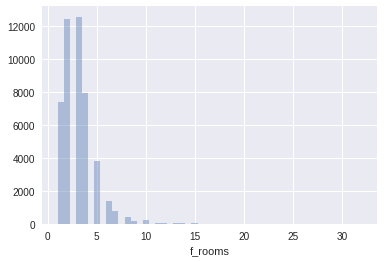

In [26]:
sns.distplot(df[~df['f_rooms'].isnull()]['f_rooms'],norm_hist=False,kde=False)

In [27]:
#Se testea el IQR a fin de interpretar gráficamente el rango sobre el cual se aplica el filtro
coeficienteIQR=3
limite_i, limite_s = valores_extremos_limites('f_rooms',coeficienteIQR)

Campo: f_rooms

Media: 3.1
Max: 32.0 ; Min: 1.0
q1= 2.0 ; q3= 4.0
IQR= 2.0; coef= 3
Linf= -4.0; Lsup= 10.0

CANT. DE OUTLIERS: 302


Una vez elegido el valor del coeficiente de IQR a aplicar, se excluyen los valores del campo asociado y se grafica nuevamente la serie:

In [0]:
df.loc[(df['f_rooms']<limite_i)|(df['f_rooms']>limite_s),'f_rooms']=np.nan

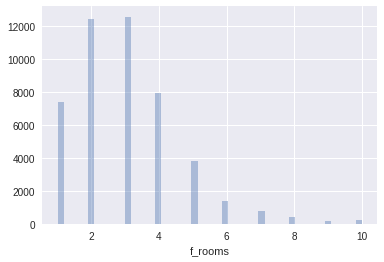

In [29]:
sns.distplot(df[~df['f_rooms'].isnull()]['f_rooms'],norm_hist=False,kde=False)

In [30]:
df['f_rooms'].describe()

count    47088.000000
mean         3.007093
std          1.582187
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: f_rooms, dtype: float64

Dados los valores, en este caso la media se ve afectada demasiado y los valores extremos se modifican sustancialmente.

**Campos FLOOR**

Se define un campo de floor final (f_floor) para almacenar los datos luego del procesamiento y se previsualizan los datos mediante un histograma de frecuencia de los valores:

In [0]:
df['f_floor']=df['floor']

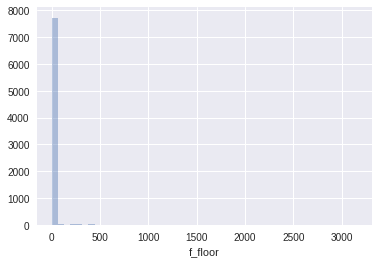

In [32]:
sns.distplot(df[~df['f_floor'].isnull()]['f_floor'],norm_hist=False,kde=False)


In [33]:
#Se testea el IQR a fin de interpretar gráficamente el rango sobre el cual se aplica el filtro
coeficienteIQR=3
limite_i, limite_s = valores_extremos_limites('f_floor',coeficienteIQR)

Campo: f_floor

Media: 17.5
Max: 3150.0 ; Min: 1.0
q1= 1.0 ; q3= 6.0
IQR= 5.0; coef= 3
Linf= -14.0; Lsup= 21.0

CANT. DE OUTLIERS: 259


Una vez elegido el valor del coeficiente de IQR a aplicar, se excluyen los valores del campo asociado y se grafica nuevamente la serie:

In [0]:
df.loc[(df['f_floor']<limite_i)|(df['f_floor']>limite_s),'f_floor']=np.nan

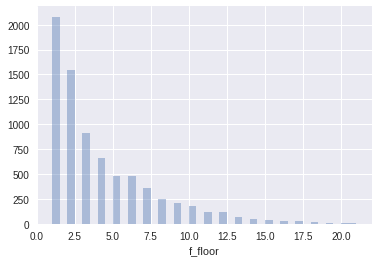

In [35]:
sns.distplot(df[~df['f_floor'].isnull()]['f_floor'],bins=40,norm_hist=False,kde=False)

In [36]:
df['f_floor'].describe()

count    7640.000000
mean        3.997382
std         3.490641
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        21.000000
Name: f_floor, dtype: float64

Debido a la naturaleza de los valores filtrados, la media cambia notablemente y tambien el valor máximo de la serie. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


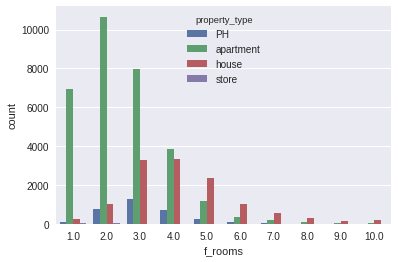

In [37]:
sns.countplot(x='f_rooms', hue='property_type', data=df)

**Campos PRECIO, SUPERFICIE y  PRECIO/M²**

Anteriormente ya se mencionó la importancia y relacion entre estos campos.
A fin de excluir los valores fuera de serie se hace un análisis por precio/m² tomando como punto de partida los campos definidos previamente y el resultado almacenado en f_price_m2_usd.

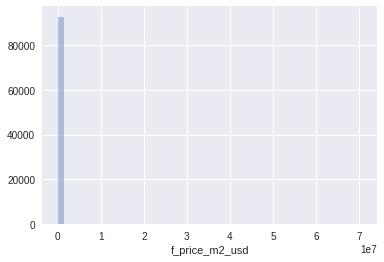

In [38]:
sns.distplot(df[~df['f_price_m2_usd'].isnull()]['f_price_m2_usd'],norm_hist=False,kde=False)

In [39]:
df[~df['f_price_m2_usd'].isnull()]['f_price_m2_usd'].sort_values(ascending=False).head(10)

65701    7.057800e+07
49274    3.528900e+07
10528    3.176010e+07
53324    2.823120e+07
55181    1.499782e+07
63886    1.146892e+07
28550    8.083828e+06
60016    6.616688e+06
20820    6.041084e+06
98781    5.928552e+06
Name: f_price_m2_usd, dtype: float64

In [40]:
#Se testea el IQR a fin de interpretar gráficamente el rango sobre el cual se aplica el filtro
coeficienteIQR=3
limite_i, limite_s = valores_extremos_limites('f_price_m2_usd',coeficienteIQR)

Campo: f_price_m2_usd

Media: 64166.4
Max: 70577999.3 ; Min: 0.6
q1= 1357.1 ; q3= 3007.7
IQR= 1650.5; coef= 3
Linf= -3594.5; Lsup= 7959.3

CANT. DE OUTLIERS: 13467


Una vez elegido el valor del coeficiente de IQR a aplicar, se excluyen los valores de los campos asociados y se grafica nuevamente la serie:

In [0]:
df.loc[(df['f_price_m2_usd']<limite_i)|(df['f_price_m2_usd']>limite_s),['f_price_m2_usd','f_price_usd','f_stot']]=np.nan


In [42]:
df[~df['f_price_m2_usd'].isnull()]['f_price_m2_usd'].sort_values(ascending=False).head(10)

11567     7950.000000
22048     7950.000000
33430     7950.000000
11428     7945.205479
42520     7936.507937
121130    7916.666667
19315     7916.666667
58041     7909.604520
59574     7906.976744
35220     7906.976744
Name: f_price_m2_usd, dtype: float64

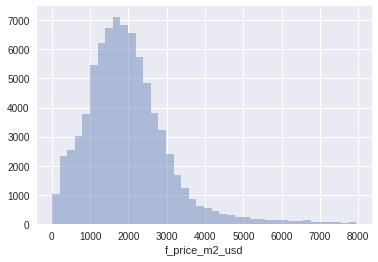

In [43]:
sns.distplot(df[~df['f_price_m2_usd'].isnull()]['f_price_m2_usd'],bins=40,norm_hist=False,kde=False)

In [44]:
df['f_price_m2_usd'].describe()

count    79458.000000
mean      1956.655797
std       1082.655018
min          0.600000
25%       1250.000000
50%       1833.333333
75%       2476.302632
max       7950.000000
Name: f_price_m2_usd, dtype: float64

En este caso la media no se ve afectada de manera importante y los límites extremos se modifican considerablemente.

In [0]:
df.loc[df['f_price_usd']==0,'f_price_usd']=np.nan
df.loc[df['f_price_m2_usd']==0,'f_price_m2_usd']=np.nan
df.loc[df['f_stot']==0,'f_stot']=np.nan

df.loc[df['f_price_m2_usd']==np.nan,'f_price_usd']=np.nan
df['f_price_usd']=df['f_price_m2_usd']*df['f_stot']

**Campos PRECIO**

Se realiza una última imputación a partir de los valores extremos de precio

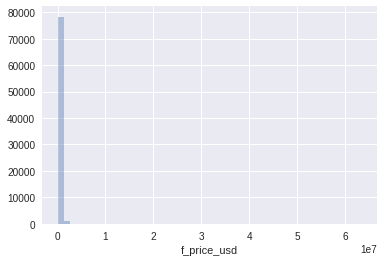

In [46]:
sns.distplot(df[~df['f_price_usd'].isnull()]['f_price_usd'],norm_hist=False,kde=False)

In [47]:
df[~df['f_price_usd'].isnull()]['f_price_usd'].sort_values(ascending=False).head(10)

110803    63520200.0
24548     46545445.0
86698     41641020.0
86675     39876570.0
17204     32818770.0
8500      27878310.0
35926     25584525.0
109632    25153999.2
24031     24261187.5
27216     23820075.0
Name: f_price_usd, dtype: float64

In [48]:
#Se testea el IQR a fin de interpretar gráficamente el rango sobre el cual se aplica el filtro
coeficienteIQR=3
limite_i, limite_s = valores_extremos_limites('f_price_usd',coeficienteIQR)

Campo: f_price_usd

Media: 255852.1
Max: 63520200.0 ; Min: 5000.0
q1= 100000.0 ; q3= 285000.0
IQR= 185000.0; coef= 3
Linf= -455000.0; Lsup= 840000.0

CANT. DE OUTLIERS: 2786


Una vez elegido el valor del coeficiente de IQR a aplicar, se excluyen los valores de los campos asociados y se grafica nuevamente la serie:

In [0]:
df.loc[(df['f_price_usd']<limite_i)|(df['f_price_usd']>limite_s),['f_price_m2_usd','f_price_usd','f_stot']]=np.nan

In [50]:
df[~df['f_price_usd'].isnull()]['f_price_usd'].sort_values(ascending=False).head(10)

40056     840000.0
20279     840000.0
34662     840000.0
92546     840000.0
15508     840000.0
40392     840000.0
80714     840000.0
104343    840000.0
49983     840000.0
44228     840000.0
Name: f_price_usd, dtype: float64

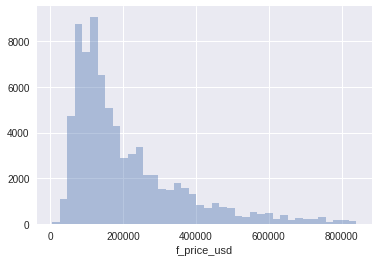

In [51]:
sns.distplot(df[~df['f_price_usd'].isnull()]['f_price_usd'],bins=40,norm_hist=False,kde=False)

In [52]:
df['f_price_usd'].describe()

count     76672.000000
mean     207102.386295
std      151771.666586
min        5000.000000
25%       99000.000000
50%      155000.000000
75%      265000.000000
max      840000.000000
Name: f_price_usd, dtype: float64

Se imputan los valores de precio por m² con valor nulo

In [0]:
df.loc[df['f_price_usd']==np.nan,'f_price_m2_usd']=np.nan

### 2.d) Corrección de precios (Imputación de valores)

**Valores según expresiones regulares**

Se intenta recuperar información faltante y una alternativa que se piensa es en extraer los datos de las cadenas de texto contenidas en los campos descriptivos (title, description y url).

Esta solución se considera podría ser peligrosa por el hecho mismo de extraer valores de precios y superficies de los campos descriptivos, los cuales poseen una gran variabilidad de formas en el ingreso de los datos y se tendría poco control al extraer las cadenas de texto.

Es por este motivo que no se realiza ningun proceso de análisis mediante expresiones regulares para completar valores faltantes según los campos 'description', 'title' y 'url'.

**Valores según ubicación y tipo de propiedad**

Para la imputación de valores se elige realizar un agrupamiento de los registros según tipo de propiedad, provincia/distrito y localidad/barrio. De esta manera, en los casos que la cantidad de anuncios lo permita, se podrán considerar descriptores estadísticos más representativos de la zona de estudio y el inmueble en venta.



Se realiza un groupby del campo *f_price_m2_usd* según *property_type*, *state_name* y *place_name*.
Para cada uno de los grupos se calcula la media, desvío y la longitud de la muestra.

In [0]:
df_group=df.loc[(~df['f_price_m2_usd'].isnull()),:].groupby(['property_type','state_name','place_name'])['f_price_m2_usd'].agg(['mean','std','count'])

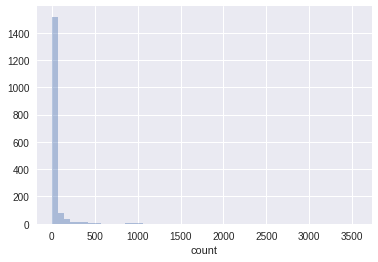

In [55]:
sns.distplot(df_group['count'],norm_hist=False,kde=False)

Se estudia la determinación de la cantidad de registros **n** para realizar la imputación a nivel de localidad/barrio, considerando que de esta manera se muestras menos espaciadas espacialmente, lo cual restringe el área de análisis y hace más eficiente el uso de los descriptores estadísticos.

In [56]:
#Cantidad de registros 'n' mínimo para considerar una imputación a nivel de localidad/barrio
n=500
df_group[df_group.loc[:,'count']>n]
df_group[df_group.loc[:,'count']>n]['count']

property_type  state_name                    place_name     
apartment      Bs.As. G.B.A. Zona Norte      Nordelta           1609
                                             Olivos              938
                                             Pilar               572
                                             Tigre              1126
               Bs.As. G.B.A. Zona Oeste      Morón               577
                                             Ramos Mejía         539
               Bs.As. G.B.A. Zona Sur        La Plata            866
                                             Lomas de Zamora     671
               Buenos Aires Costa Atlántica  Mar del Plata      3549
               Capital Federal               Almagro             796
                                             Balvanera           543
                                             Barrio Norte        884
                                             Belgrano           2056
                                          

In [57]:
df_group[df_group.loc[:,'count']>n]['count'].count()

30

In [58]:
print('Para n= %d, se tienen %d grupos de localidades posibles a filtrar.' % (n, df_group[df_group.loc[:,'count']>n]['count'].count()))

Para n= 500, se tienen 30 grupos de localidades posibles a filtrar.


El siguiente es el histograma de cantidad de localidades/barrios según tipo de propiedad con más de *n* registros:

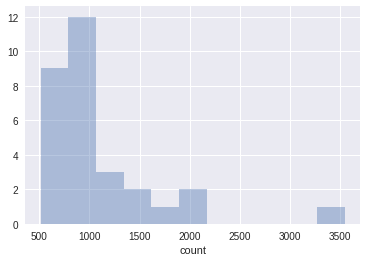

In [59]:
sns.distplot(df_group[df_group.loc[:,'count']>n]['count'],norm_hist=False,kde=False)

A modo ilustrativo y como ejemplo, se toma el caso de los departamentos en el barrio de Belgrano, grupo que posee una importante cantidad de registros:

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


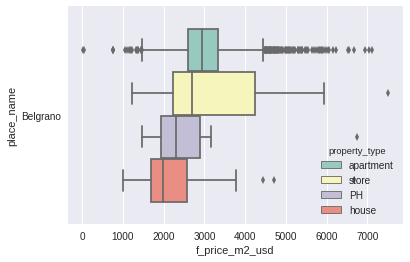

In [60]:
sns.boxplot(y='place_name', x='f_price_m2_usd', hue='property_type', data=df[df.loc[:,'place_name']=='Belgrano'], palette="Set3")

In [61]:
df[(df['place_name']=='Belgrano')].groupby('property_type')['price_usd_per_m2'].describe().sort_values(by='count',ascending = False)

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
apartment,1974.0,3192.416533,1098.778718,31.369688,2632.971939,3007.551760,3460.000301,20833.333333
house,81.0,2436.400698,920.580605,1000.000000,1800.000000,2361.396304,2812.500000,6666.666667
store,38.0,3447.382531,1657.159328,128.191143,2251.010101,3350.746269,4498.168842,8333.333333
PH,34.0,2304.130413,502.852223,1469.387755,1956.594195,2239.279588,2753.409091,3153.846154


In [62]:
df[df.loc[:,'place_name']=='Belgrano']['f_price_m2_usd'].describe()

count    2181.000000
mean     3014.100555
std       794.419503
min        26.076636
25%      2547.826087
50%      2918.918919
75%      3320.610687
max      7500.000000
Name: f_price_m2_usd, dtype: float64

Se definen una serie de funciones que tienen por objetivo realizar el siguiente procedimiento:


1.   Agrupar los anuncios por campos: (property_type; state_name, place_name)
2.   En los grupos que la cantidad de anuncios es mayor a un número nc, se aplica un filtro
3.   Para cada uno de los anteriores, se determinan los valores que se encuentran por fuera de zc desvíos respecto a la media
4.   Se imputan esos registros con el valor del precio por m² de cada grupo
5.   De los registros que restan, se consideran aquellos que tienen más de np registrios por provincia
6.   Se determinan los valores más lejanos a zp desvíos de la media
7.   Se reemplaza el precio por m² con el valor medio del grupo



In [0]:
#Filtro a nivel de ciudades
def filtrar_extremos_ciudades(df=df,campo_precio='f_price_m2_usd',
                                  lista=['property_type','state_name','place_name'],
                                  campo_menor='place_name',
                                  limite_n=300,
                                  limite_z=3
                                 ):
      #Input: df a emplear, campo a filtrar, lista de campos para hacer groupby, campo de menor jerarquía
      #       límite mínimo de cantidad de registros para hacer el análisis
      #       límite de z desvíos respecto a la media para hacer la imputación
      #Output:Campos con estadísticos para cada grupo y máscaras booleanas según n y z
      
      df_aux=df.loc[(~df[campo_menor].isnull())&(~df[campo_precio].isnull()),:]
      
      df['filtroC_media']=df_aux.groupby(lista)[campo_precio].transform(lambda x : x.mean())
      df['filtroC_std']=df_aux.groupby(lista)[campo_precio].transform(lambda x : x.std())
      df['filtroC_count']=df_aux.groupby(lista)[campo_precio].transform(lambda x : x.count())

      df['filtroC_z']=(df[campo_precio]-df['filtroC_media'])/df['filtroC_std']
      df['filtroC_maskN']=(df['filtroC_count']>limite_n)
      df['filtroC_maskZ']=(df['filtroC_z'].abs()>limite_z)  

      return ((df['filtroC_maskN']&df['filtroC_maskZ']).sum())


    
#Filtro a nivel de provincias
def filtrar_extremos_provincias(df=df,campo_precio='f_price_m2_usd',
                                    lista=['property_type','state_name'],
                                    campo_menor='state_name',
                                    limite_n=50,
                                    limite_z=5
                                   ):

      #Input: df a emplear, campo a filtrar, lista de campos para hacer groupby,
      #       campo de menor jerarquía (provincias/distritos),
      #       límite mínimo de cantidad de registros para hacer el análisis
      #       límite de z desvíos respecto a la media para hacer la imputación
      #Output:Campos con estadísticos para cada grupo y máscaras booleanas según n y z

      df_aux=df.loc[(~df[campo_menor].isnull())&(~df[campo_precio].isnull()),:]
      
      df['filtroP_media']=df_aux.groupby(lista)[campo_precio].transform(lambda x : x.mean())
      df['filtroP_std']=df_aux.groupby(lista)[campo_precio].transform(lambda x : x.std())
      df['filtroP_count']=df_aux.groupby(lista)[campo_precio].transform(lambda x : x.count())

      df['filtroP_z']=(df[campo_precio]-df['filtroP_media'])/df['filtroP_std']
      df['filtroP_maskN']=(df['filtroP_count']>limite_n)
      df['filtroP_maskZ']=(df['filtroP_z'].abs()>limite_z)  

      return ((df['filtroP_maskN']&df['filtroP_maskZ']).sum())

    

#Borrar columnas de filtros ciudades y provincias
def filtrar_extremos_borrarColumnas():
      #Borra las columnas auxiliares empleadas por las funciones anteriores
      df.drop(['filtroP_media','filtroP_std','filtroP_count','filtroP_z', 'filtroP_maskN', 'filtroP_maskZ',
               'filtroC_media','filtroC_std','filtroC_count','filtroC_z','filtroC_maskN','filtroC_maskZ'],
              axis=1, inplace=True)
  
  

#Secuencia para aplicar filtros segun funciones anteriores
#El valor a imputar es la media del grupo
def filtar_extremos_secuencia(df=df,campo_precio='f_price_m2_usd',
                      limite_nc=500, limite_np=20,
                      limite_zc=3, limite_zp=5,
                     ):

      filtrar_extremos_ciudades(df=df,
                                campo_precio=campo_precio,
                                limite_n=limite_nc,
                                limite_z=limite_zc)
      #df.loc[df['filtroC_maskN']&df['filtroC_maskZ'],campo_precio]=df['filtroC_media']
      df.loc[df['filtroC_maskN']&df['filtroC_maskZ'],campo_precio]=np.nan
      n=(df['filtroC_maskN']&df['filtroC_maskZ']).sum()
      print('Se borraron %d valores en ciudades con más de %d registros y zlimite de %d' % (n, limite_nc, limite_zc))


      filtrar_extremos_provincias(df=df,
                                  limite_n=limite_np,
                                  limite_z=limite_zp)

      #df.loc[(~df['filtroC_maskN'])&df['filtroP_maskN']&df['filtroP_maskZ'],campo_precio]=df['filtroP_media']
      df.loc[(~df['filtroC_maskN'])&df['filtroP_maskN']&df['filtroP_maskZ'],campo_precio]=np.nan
      n=(df['filtroP_maskN']&df['filtroP_maskZ']).sum()
      print('Se borraron %d valores en provincias con más de %d registros y zlimite de %d' % (n, limite_np, limite_zp))

      df['f_price_m2_usd'].replace([np.inf, -np.inf], np.nan)
      filtrar_extremos_borrarColumnas()
      return

In [64]:
filtar_extremos_secuencia(limite_nc=500, limite_zc=3, limite_np=50, limite_zp=4)

Se borraron 388 valores en ciudades con más de 500 registros y zlimite de 3
Se borraron 388 valores en provincias con más de 50 registros y zlimite de 4


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


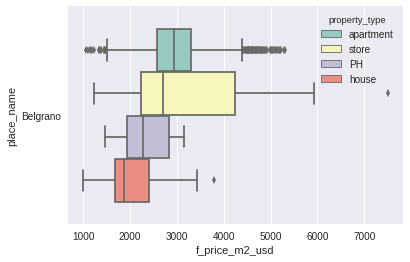

In [65]:
sns.boxplot(y='place_name', x='f_price_m2_usd', hue='property_type', data=df[df.loc[:,'place_name']=='Belgrano'], palette="Set3")

In [66]:
df[(df['place_name']=='Belgrano')].groupby('property_type')['f_price_m2_usd'].describe().sort_values(by='count',ascending = False)

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
apartment,2017.0,2998.241127,649.120873,1055.555556,2582.417582,2932.432432,3309.734513,5300.000000
house,45.0,2100.481246,630.318177,1000.000000,1687.500000,1863.117871,2407.407407,3783.783784
PH,39.0,2310.335345,510.605548,1469.387755,1927.721088,2268.041237,2836.247086,3153.846154
store,37.0,3277.598750,1534.937133,1222.222222,2227.272727,2696.969697,4230.769231,7500.000000


In [67]:
df[df.loc[:,'place_name']=='Belgrano']['f_price_m2_usd'].describe()

count    2138.000000
mean     2971.631544
std       690.113692
min      1000.000000
25%      2545.843046
50%      2911.764706
75%      3298.724681
max      7500.000000
Name: f_price_m2_usd, dtype: float64

In [68]:
df_group=df.loc[(~df['f_price_m2_usd'].isnull()),:].groupby(['property_type','state_name','place_name'])['f_price_m2_usd'].agg(['mean','std','count'])
df_group[df_group.loc[:,'count']>n]

mean  \
property_type state_name                   place_name                     
apartment     Bs.As. G.B.A. Zona Norte     Nordelta         2555.403253   
                                           Olivos           3142.443364   
                                           Pilar            1793.796352   
                                           Tigre            2223.931865   
              Bs.As. G.B.A. Zona Oeste     Morón            1725.306985   
                                           Ramos Mejía      2059.547788   
              Bs.As. G.B.A. Zona Sur       La Plata         1740.665474   
                                           Lomas de Zamora  2107.776841   
              Buenos Aires Costa Atlántica Mar del Plata    1925.101138   
              Capital Federal              Almagro          2211.064131   
                                           Balvanera        1930.394210   
                                           Barrio Norte     2893.983544   
                                           Belgrano         2998.241127   
                                           Caballito        2462.430629   
                                           Flores           2069.410544   
                                           Nuñez            2986.184423   
                                           Palermo          3190.294140   
                                           Recoleta         3166.021291   
                                           San Telmo        2315.474474   
                                           Villa Crespo     2507.445363   
                                           Villa Urquiza    2511.365822   
              Córdoba                      Córdoba          1588.759568   
              Santa Fe                     Rosario          1861.161068   
house         Bs.As. G.B.A. Zona Norte     Benavidez         605.929641   
                                           Escobar          1160.334891   
                                           Nordelta         1762.038378   
                                           Pilar            1184.516112   
                                           Tigre            1490.728711   
              Buenos Aires Costa Atlántica Mar del Plata     742.470649   
              Córdoba                      Córdoba           981.812014   

                                                                   std  count  
property_type state_name                   place_name                          
apartment     Bs.As. G.B.A. Zona Norte     Nordelta         653.836268   1590  
                                           Olivos           767.619608    927  
                                           Pilar            770.508021    559  
                                           Tigre            432.818931   1102  
              Bs.As. G.B.A. Zona Oeste     Morón            323.785107    572  
                                           Ramos Mejía      484.957151    534  
              Bs.As. G.B.A. Zona Sur       La Plata         406.095615    860  
                                           Lomas de Zamora  509.795983    667  
              Buenos Aires Costa Atlántica Mar del Plata    499.549875   3509  
              Capital Federal              Almagro          434.357445    784  
                                           Balvanera        441.485383    540  
                                           Barrio Norte     742.548964    868  
                                           Belgrano         649.120873   2017  
                                           Caballito        468.587288   1823  
                                           Flores           384.190321    960  
                                           Nuñez            713.798152    557  
                                           Palermo          840.366087   1985  
                                           Recoleta         762.347363   1145  
                                           San Telmo        520.35

In [69]:
df_group[df_group.loc[:,'count']>1000]

mean  \
property_type state_name                   place_name                   
apartment     Bs.As. G.B.A. Zona Norte     Nordelta       2555.403253   
                                           Tigre          2223.931865   
              Buenos Aires Costa Atlántica Mar del Plata  1925.101138   
              Capital Federal              Belgrano       2998.241127   
                                           Caballito      2462.430629   
                                           Palermo        3190.294140   
                                           Recoleta       3166.021291   
                                           Villa Urquiza  2511.365822   
              Córdoba                      Córdoba        1588.759568   
house         Bs.As. G.B.A. Zona Norte     Pilar          1184.516112   
                                           Tigre          1490.728711   

                                                                 std  count  
property_type state_name                   place_name                        
apartment     Bs.As. G.B.A. Zona Norte     Nordelta       653.836268   1590  
                                           Tigre          432.818931   1102  
              Buenos Aires Costa Atlántica Mar del Plata  499.549875   3509  
              Capital Federal              Belgrano       649.120873   2017  
                                           Caballito      468.587288   1823  
                                           Palermo        840.366087   1985  
                                           Recoleta       762.347363   1145  
                                           Villa Urquiza  389.542687   1028  
              Córdoba                      Córdoba        446.372325   1015  
house         Bs.As. G.B.A. Zona Norte     Pilar          537.064414   1102  
                                           Tigre          503.151865   1546

### 2.e) Recálculo de columnas (precio y precio/m²)

In [0]:
df['f_price_usd']=np.nan
df.loc[df['f_price_usd']==0,'f_price_usd']=np.nan
df.loc[df['f_stot']==0,'f_stot']=np.nan
df['f_price_usd']=df['f_price_m2_usd']*df['f_stot']

In [71]:
sum(~df['f_price_usd'].isna())

75896

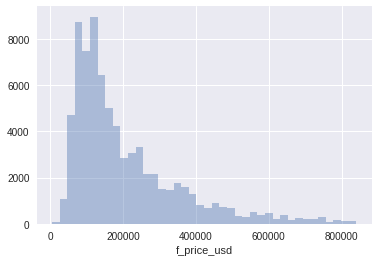

In [72]:
sns.distplot(df[~df['f_price_usd'].isnull()]['f_price_usd'],bins=40,norm_hist=False,kde=False)

### 2.f) Búsqueda de expresiones regulares

**Dummies**

Se definen dos funciones para el procesamiento de las dummies.
* La primera genera una columna dummy para una expresión regular dada y con el nombre asignado
* La segunda hace una iteración dentro de un diccionario que contiene nombre de la dummy y expresión regular a detectar



In [0]:
def dummy_ER(nombre, exp_reg,DataFrame=df):
    #Emplea los campos 'description', 'properati_url' y 'title'
    #ya que son los que contienen cadenas de texto no extructuradas de las cuales se podría
    #extraer informacion adicional para completar campos faltantes
    #Input: Nombre a llamar al campo y expresión regular a buscar
    #Output: Columna Dummie con 1 donde obtuvo algun hallazgo y 0 en las filas que tuvo nan

    filter_ER = extraer_ER_crudo(df,'c_desc_title_url',exp_reg).fillna('x')
    filter_ER.loc[:,0] = [0 if 'x' in x else 1 for x in filter_ER.loc[:,0]]
    return filter_ER.iloc[:,0]
  
def dummy_crear(diccionario,DataFrame=df):
    #Input: {'nombre': 'expresion_regular'}
    #        Diccionario con claves de nombres de cada característica y expresión regular asociada
    #        ejemplo: {'piscina': '(pileta|piscina)'}
    #Output: df con columnas dummys asociadas para cada busqueda
    lst = []
    lst=diccionario.keys()
    for k in lst:
      DataFrame[k]=dummy_ER(k, diccionario[k])
      print(str(k)+ '--->' + str(DataFrame[k].values.sum()))
    print('\n' + str(len(diccionario)) + ' DUMMIES CREADAS')
    return

Se crea el diccionario con las dummys consideradas y la expresión regular a extraer:

In [74]:
### Link para probar expresiones regulares
### https://regexr.com/
### https://regex101.com/


diccionario= {
                   'estrenar': '(estrenar|nuevo|impecable)',
                   'reciclado':'(recicl)',
    
                   'aire_ac':'(aire ac|aires ac|split)',
                   'calefaccion': '(calefaccion|losa radiante|calefactor)',
                   'termotanque': '(termotanque)',
    
                   'lavadero': '(lavadero)',
                   'cochera':'(garage|garaje|cochera|vehiculo|coche)',
                   'pileta': '(pileta|piscina)',
                   'terraza': '(terraza)',
                   'balcon': '(balcon)',
                   'jardin': '(patio|jardin)',
                   'parrilla':'(parrilla|asador)',
                   'quincho':'(quincho)',
                   'baulera':'(baulera)',
                   'vestidor':'(vestidor)',
                   'dependencia':'(dependencia)',
                   'playroom':'(playroom)',
                   'hidromasaje':'(hidromasaje)', 
                   'jacuzzi': '(jacuzzi|jacuzi)',

                   'sum':'( sum )',
                   'gimnasio':'(gimnasio|gym)',
                   'amenities':'(amenities)',
                   'laundry': '(laundry)',
                   'solarium':'(solarium)',
                   'spa':'(sauna)',

                   'acceso': '(autopista|av|avenida|panamericana|acceso|subte|metro|metrobus)',
                   'ascensor':'(ascensor)',
                   'escalera':'(escalera)',
                   'seguridad': '(seguridad|vigilancia|camara|portero)',
                   'portero': '(portero)',
    
                   'frente':'(frente| fte)',
                   'contrafrente':'(contrafrente|cfte)',
                   'luminoso':'(luminos)',
                   'o_norte': '(orientacion norte|al norte)',
                   'o_sur': '(orientacion sur|al sur)',
                   'o_este': '(orientacion este|al este)',
                   'o_oeste': '(orientacion oeste|al oeste)',

                   'credito':'(credito|hipotecario|financiacion|financiamiento)',
                   'reparar':'(reparar|reparacion)',
                   'ap_profesional':'(apto profesional)',

                  }

dummy_crear(diccionario)

estrenar--->25561
reciclado--->6516
aire_ac--->17147
calefaccion--->19716
termotanque--->4845
lavadero--->44920
cochera--->60460
pileta--->32984
terraza--->27804
balcon--->43712
jardin--->35603
parrilla--->38354
quincho--->13213
baulera--->10980
vestidor--->18293
dependencia--->13794
playroom--->4767
hidromasaje--->7754
jacuzzi--->3896
sum--->11886
gimnasio--->9695
amenities--->11452
laundry--->7263
solarium--->12929
spa--->4035
acceso--->88564
ascensor--->8823
escalera--->8428
seguridad--->16445
portero--->3108
frente--->41203
contrafrente--->9615
luminoso--->32836
o_norte--->1952
o_sur--->917
o_este--->1582
o_oeste--->1007
credito--->20256
reparar--->184
ap_profesional--->5091

40 DUMMIES CREADAS


Se crea un diccionario a ser asignado en un DataFrame para elaborar un gráfico de barras

**Ambientes**

La cantidad de ambientes es un campo que puede ser completado a partir de los campos descriptivos. Para ello se analizarán los campos de texto empleando las funciones definidas anteriormente.

In [75]:
#cantidad de ambientes
extraer_ER_groupby(df,'c_desc_title_url','(\d|\w+) (?:amb)').head(10)

,0
0,
2,13670
3,13466
4,7768
los,4120
dos,2904
1,2791
5,2280
tres,1470
un,1155


Se definen dos funciones auxiliares para extraer la empresion regular deseada y reemplazarla por la cantidad de ambientes segun un diccionario.

In [0]:
def rooms_dict(diccionario,DataFrame):
    #Input: {'texto': 'numero'}
    #        Diccionario con claves de nombres de cada característica y numero de ambientes asociados
    #        ejemplo: {'dos': 2}
    #Output: creacion sobre el campo f_rooms segun valor
    ni=DataFrame['f_rooms'].isnull().values.sum()
    lst = []
    lst=diccionario.keys()
    for k in lst:
      mi=DataFrame['f_rooms'].isnull().values.sum()
      DataFrame.loc[(DataFrame['f_rooms'].isnull()) & (DataFrame.loc[:,'aux']==k),'f_rooms']=diccionario[k]
      mf=DataFrame['f_rooms'].isnull().values.sum()
      if (mi-mf)>0:
        print ('\t'+'Clave: '+k+'  - Reemplazos: ' + str(mi-mf))
    nf=DataFrame['f_rooms'].isnull().values.sum()
    return print('\t'+'TOTAL DE REEMPLAZOS: ' + str(ni-nf))

  
def rooms_crear(diccionario,ER,DataFrame=df):
    #Input: {'texto': 'numero'}
    #        Diccionario con claves de nombres de cada característica y numero de ambientes asociados
    #        ejemplo: {'dos': 2}
    #        ER: expresión regular a buscar
    #Output: creacion sobre el campo f_rooms segun valor
    nulls_i=DataFrame['f_rooms'].isnull().values.sum()
    print('\n'+'Nulos iniciales:'+str(nulls_i)+'\n'+'ER:'+ER+'\n')
    
#     print('CAMPO: '+'rooms')
    ni=DataFrame['f_rooms'].isnull().values.sum()
#     DataFrame.loc[DataFrame['f_rooms'].isnull(),'f_rooms']=DataFrame['rooms']
#     nf=DataFrame['f_rooms'].isnull().values.sum()
#     print('\t'+'TOTAL DE REEMPLAZOS: ' + str(ni-nf))
#     print('\t'+ str(((ni-nf)/nulls_i)*100) + '%')    
    
    for c in ['c_description','c_title','c_properati_url']:
      ni=DataFrame['f_rooms'].isnull().values.sum()
      DataFrame['aux']=extraer_ER_crudo(DataFrame,c,ER)
      print('CAMPO: '+c)
      rooms_dict(diccionario,DataFrame)
      nf=DataFrame['f_rooms'].isnull().values.sum()
      print('\t'+ str(((ni-nf)/nulls_i)*100) + '%')
    
    ni=DataFrame['rooms'].isnull().values.sum()
    print('\n'+'REEMPLAZOS TOTALES: ' + str(nulls_i-nf))
    print(str(((nulls_i-nf)/nulls_i)*100) + '%'+'\n')
    
    return
    

Diccionario de reemplazo de cadena de texto extraída de campos descriptivos y valor numérico para asignar al campo f_rooms

In [77]:
diccionario={'1':1,
             '2':2,
             '3':3,
             '4':4,
             '5':5,
             '6':6,
             '7':7,
             '8':8,
             '9':9,
             '10':10,
             '11':11,
             '12':12,
             '13':13,
             '14':14,
             '15':15,
             'mono':0,
             'un':1,
             'dos':2,
             'tres':3,
             'cuatro':4,
             'cinco':5,
             'seis':6,
             'siete':7,
             'ocho':8,
             'nueve':9,
             'diez':10,
             'once':11,
             'doce':12,
             'trece':13,
             'catorce':14,
             'quince':15,
                  }


rooms_crear(diccionario, ER='(\d|\w+) (?:amb)')

rooms_crear(diccionario,ER='(monoamb)')


Nulos iniciales:74132
ER:(\d|\w+) (?:amb)

CAMPO: c_description
	Clave: 1  - Reemplazos: 1007
	Clave: 2  - Reemplazos: 6140
	Clave: 3  - Reemplazos: 6074
	Clave: 4  - Reemplazos: 3569
	Clave: 5  - Reemplazos: 1062
	Clave: 6  - Reemplazos: 315
	Clave: 7  - Reemplazos: 117
	Clave: 8  - Reemplazos: 14
	Clave: 9  - Reemplazos: 14
	Clave: 10  - Reemplazos: 6
	Clave: 11  - Reemplazos: 11
	Clave: 12  - Reemplazos: 2
	Clave: 14  - Reemplazos: 4
	Clave: mono  - Reemplazos: 449
	Clave: un  - Reemplazos: 636
	Clave: dos  - Reemplazos: 1308
	Clave: tres  - Reemplazos: 717
	Clave: cuatro  - Reemplazos: 162
	Clave: cinco  - Reemplazos: 28
	Clave: seis  - Reemplazos: 7
	Clave: siete  - Reemplazos: 4
	Clave: nueve  - Reemplazos: 1
	Clave: diez  - Reemplazos: 1
	TOTAL DE REEMPLAZOS: 21648
	29.201964064101873%
CAMPO: c_title
	Clave: 1  - Reemplazos: 131
	Clave: 2  - Reemplazos: 475
	Clave: 3  - Reemplazos: 727
	Clave: 4  - Reemplazos: 608
	Clave: 5  - Reemplazos: 244
	Clave: 6  - Reemplazos: 88
	Clave:

## 3.Análisis posterior a la limpieza y exportacion

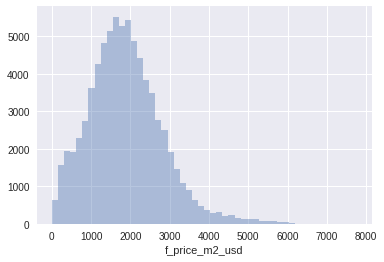

In [78]:
sns.distplot(df[(~df['f_price_m2_usd'].isnull())]['f_price_m2_usd'],norm_hist=False,kde=False)

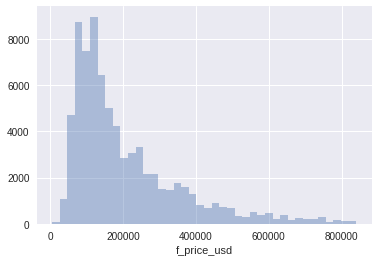

In [79]:
sns.distplot(df[~df['f_price_usd'].isnull()]['f_price_usd'],bins=40,norm_hist=False,kde=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


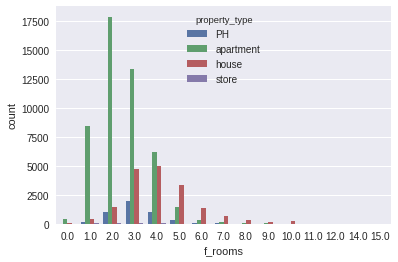

In [80]:
sns.countplot(x='f_rooms', hue='property_type', data=df)

In [81]:
df.shape

(121220, 102)

In [0]:
df_clean=df
del df

In [0]:
# df_clean.to_csv('df_clean.csv')
# files.download('df_clean.csv')

# B. PREDICCIÓN DE PRECIOS

## 0.Importación de librerías y archivos de datos

**Se importan las librerías a utilizar**

In [0]:
% matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 5, 5

import numpy as np
import pandas as pd
from scipy import stats
from scipy.sparse import hstack
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## 1.Preparación de los datos

**Se carga el DataFrame completo luego de haber hecho la limpieza inicial, filtro de outliers, imputación de valores, etc **

In [85]:
#df = pd.read_csv('df_clean.csv',encoding = 'UTF-8')  #En caso de importar directamente el csv del paso anterior
df=df_clean
df.shape

(121220, 102)

In [86]:
df.head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,contrafrente,luminoso,o_norte,o_sur,o_este,o_oeste,credito,reparar,ap_profesional,aux
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,0,0,0,0,0,0,1,0,0,NaN
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,0,0,0,0,0,0,0,0,0,NaN
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,0,0,0,0,0,0,1,0,0,NaN
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,1,0,0,0,0,0,0,0,0,NaN
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,1,0,0,0,0,0,0,0,0,NaN


Se verifica la lista completa del DataFrame cargado. A partir de ello se determinan las columnas sobre las cuales se trabajará considerando las siguientes variables:


*  A predecir -------> individualización de la serie para evitar mezclar los datos
*  Comb. lineal ----> se excluyen las combinaciones lineales que tengan en cuenta la variable a predecir
*  Categóricas ---->  armado de dummies
*  Continuas ------->  elaboración de features auxiliares según combinaciones o funciones de éstas
*  Faltantes ---------> para creación de indicadores según datos faltantes



In [87]:
list(df.columns)

['Unnamed: 0',
 'operation',
 'property_type',
 'place_name',
 'place_with_parent_names',
 'country_name',
 'state_name',
 'geonames_id',
 'lat-lon',
 'lat',
 'lon',
 'price',
 'currency',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'surface_total_in_m2',
 'surface_covered_in_m2',
 'price_usd_per_m2',
 'price_per_m2',
 'floor',
 'rooms',
 'expenses',
 'properati_url',
 'description',
 'title',
 'image_thumbnail',
 'operation-null',
 'property_type-null',
 'place_name-null',
 'place_with_parent_names-null',
 'country_name-null',
 'state_name-null',
 'geonames_id-null',
 'lat-lon-null',
 'lat-null',
 'lon-null',
 'price-null',
 'currency-null',
 'price_aprox_local_currency-null',
 'price_aprox_usd-null',
 'surface_total_in_m2-null',
 'surface_covered_in_m2-null',
 'price_usd_per_m2-null',
 'price_per_m2-null',
 'floor-null',
 'rooms-null',
 'expenses-null',
 'c_description',
 'c_title',
 'c_properati_url',
 'c_desc_title_url',
 'f_price',
 'f_currency',
 'f_cambio',
 'f_price_usd

### 1.a) Variable a predecir

Se consideran dos opciones como posibles datos a predecir:


*  Precio en dólares
*  Precio en dólares por m²

Dado que la superficie se tomará como un valor de x, se considerará un único campo de y a predecir y el otro se descartará.
Esto se hace ya que se tendría una combinación lineal entre los campos (P = p · A).


In [0]:
y_price_usd    = df['f_price_usd'].rename('y_price_usd')
y_price_m2_usd = df['f_price_m2_usd'].rename('y_price_m2_usd')

### 1.b) Creación de dummies

**Tipo de propiedad**

In [89]:
#drop_first=True en este caso elimina PH
propiedad=pd.get_dummies(df['property_type'],prefix='tipo',drop_first=True)
print(propiedad.shape,'\n',type(propiedad))

#propiedad=pd.get_dummies(df['property_type'],prefix='tipo',drop_first=True,sparse=True)

(121220, 3) 
 <class 'pandas.core.frame.DataFrame'>


In [90]:
propiedad.head()

,tipo_apartment,tipo_house,tipo_store
0,0,0,0
1,1,0,0
2,1,0,0
3,0,0,0
4,1,0,0


**Ubicación geográfica**

En este caso se trabaja con el campo equivalente a distritos que es una combinación entre provincias y zonas características.
Se podría haber mejorado la limpieza de datos y extraer los campos de 'place_with_parent_names' para analizar otro grado de detalle sin cargar demasiados parámetros.

In [91]:
distrito=pd.get_dummies(df['state_name'],prefix='distrito',drop_first=True)
# distrito=pd.get_dummies(df['place_with_parent_names'],prefix='PL',drop_first=True)
print(distrito.shape,'\n',type(distrito))

# ['state_name','place_name']
#distrito=pd.get_dummies(df, columns=['state_name','place_name'], sparse=True)

(121220, 27) 
 <class 'pandas.core.frame.DataFrame'>


In [92]:
distrito.head()

,distrito_Bs.As. G.B.A. Zona Oeste,distrito_Bs.As. G.B.A. Zona Sur,distrito_Buenos Aires Costa Atlántica,distrito_Buenos Aires Interior,distrito_Capital Federal,distrito_Catamarca,distrito_Chaco,distrito_Chubut,distrito_Corrientes,distrito_Córdoba,...,distrito_Neuquén,distrito_Río Negro,distrito_Salta,distrito_San Juan,distrito_San Luis,distrito_Santa Cruz,distrito_Santa Fe,distrito_Santiago Del Estero,distrito_Tierra Del Fuego,distrito_Tucumán
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Campos descriptivos según anuncio**

Se consideran los campos ya trabajados anteriormente y extraídos mediante expresiones regulares

In [93]:
lst=[
 'estrenar',
 'reciclado',
 'aire_ac',
 'calefaccion',
 'termotanque',
 'lavadero',
 'cochera',
 'pileta',
 'terraza',
 'balcon',
 'jardin',
 'parrilla',
 'quincho',
 'baulera',
 'vestidor',
 'dependencia',
 'playroom',
 'hidromasaje',
 'jacuzzi',
 'sum',
 'gimnasio',
 'amenities',
 'laundry',
 'solarium',
 'spa',
 'acceso',
 'ascensor',
 'escalera',
 'seguridad',
 'portero',
 'frente',
 'contrafrente',
 'luminoso',
 'o_norte',
 'o_sur',
 'o_este',
 'o_oeste',
 'credito',
 'reparar',
 'ap_profesional',
   ]

descripcion= df.loc[:,lst]
descripcion.columns = ['desc_' + str(col) for col in descripcion.columns]
descripcion.fillna(0,inplace=True)
print(descripcion.shape,'\n',type(descripcion))


#descripcion=descripcion.to_sparse()

(121220, 40) 
 <class 'pandas.core.frame.DataFrame'>


In [94]:
descripcion.head()

,desc_estrenar,desc_reciclado,desc_aire_ac,desc_calefaccion,desc_termotanque,desc_lavadero,desc_cochera,desc_pileta,desc_terraza,desc_balcon,...,desc_frente,desc_contrafrente,desc_luminoso,desc_o_norte,desc_o_sur,desc_o_este,desc_o_oeste,desc_credito,desc_reparar,desc_ap_profesional
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


### 1.c) Cuantitativas e indicadores de faltantes

Se seleccionan las columnas a tener en cuenta como campos cuantitativos y se incorporan indicadores de valores faltantes.

In [0]:
#Funcion para crear una serie booleana según si un campo contiene datos o es nulo

def indicar_nulos(df1,df2,lista):
   for col in lista:
      df2[str(col)+'-null']=df1[str(col)].isnull()*1
      df2[str(col)+'-null']=df2[str(col)+'-null'].astype('bool')

In [96]:
lst=['f_stot',
     'f_scub',
     'f_rooms',
     'f_floor',
     'expenses']
lst2=['stot',
      'scub',
      'rooms',
      'floor',
      'expenses']


cuantitativas_null=pd.DataFrame()

cuantitativas= df.loc[:,lst]
cuantitativas.columns = lst2

indicar_nulos(cuantitativas,cuantitativas_null,lst2)

cuantitativas.fillna(0,inplace=True)

#cuantitativas=cuantitativas.drop(columns='price_usd',axis=1).to_sparse()

print(cuantitativas.shape,'\n',type(cuantitativas))
print(cuantitativas_null.shape,'\n',type(cuantitativas_null))

(121220, 5) 
 <class 'pandas.core.frame.DataFrame'>
(121220, 5) 
 <class 'pandas.core.frame.DataFrame'>


### **1.d) Creación de funciones y combinaciones**

Para este conjunto de campos, se analizan distintas exprersionenes que podrían funcionar bien como predictores y en caso de no aportar, el modelo le asignara coeficientes bajos/nulos.

In [0]:
for funcion in [np.log,
                np.sqrt,
#                 np.log2,
#                 np.log10,
#                 np.exp,
                ]:
                
  f = str(funcion.__name__)
  cuantitativas['stot_'+f]=cuantitativas['stot'].apply(funcion)
  cuantitativas['stot_'+f]=cuantitativas['stot_'+f].replace([np.inf, -np.inf], 0)
# cuantitativas_poly['expenses_'+f]=cuantitativas_poly['expenses'].apply(funcion)
# cuantitativas_poly['stot_log^2']=cuantitativas_poly['stot_log']**2

# cuantitativas['stot_inv'] = cuantitativas['stot'] ** (-1)
# cuantitativas['stot_inv'] = cuantitativas['stot_inv'].replace([np.inf, -np.inf], 0)

In [98]:
cuantitativas.head()

,stot,scub,rooms,floor,expenses,stot_log,stot_sqrt
0,55.0,40.0,2.0,0.0,0.0,4.007333,7.416198
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,55.0,55.0,2.0,0.0,0.0,4.007333,7.416198
3,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000
4,35.0,35.0,2.0,0.0,0.0,3.555348,5.916080


In [99]:
cuantitativas_null.head()

,stot-null,scub-null,rooms-null,floor-null,expenses-null
0,False,False,False,True,True
1,True,True,True,True,True
2,False,False,False,True,True
3,True,True,False,True,True
4,False,False,False,True,True


Se crean todas las combinaciones posibles de grado 3 que pueda haber entre ellas.

In [100]:
df_aux = pd.concat([
#                     propiedad,
                    cuantitativas,
                    cuantitativas_null,
                    ],
                    axis=1)

poly=PolynomialFeatures(3,include_bias=True,interaction_only=False,)

df_poly=pd.DataFrame(data=poly.fit_transform(df_aux), 
                                columns=poly.get_feature_names(df_aux.columns))

del df_aux
df_poly.head()



,1,stot,scub,rooms,floor,expenses,stot_log,stot_sqrt,stot-null,scub-null,...,rooms-null^3,rooms-null^2 floor-null,rooms-null^2 expenses-null,rooms-null floor-null^2,rooms-null floor-null expenses-null,rooms-null expenses-null^2,floor-null^3,floor-null^2 expenses-null,floor-null expenses-null^2,expenses-null^3
0,1.0,55.0,40.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,55.0,55.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,1.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,35.0,35.0,2.0,0.0,0.0,3.555348,5.916080,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


A fin de disminuir la memoria, se intenta midificar los tipos de datos de las series dummies por booleanas.

In [101]:
propiedad          = propiedad.astype('bool')
distrito           = distrito.astype('bool')
descripcion        = descripcion.astype('bool')


print(df.shape,'\n',type(df))

(121220, 102) 
 <class 'pandas.core.frame.DataFrame'>


### 1.e) Dataframe limpio

Se genera el datast limpio y con las series procesadas de manera tal de poder trabajarlo en un modelo.

In [115]:
df_poly.shape

(121220, 455)

In [102]:
df=pd.concat([df_poly,
              propiedad,
              distrito,
              descripcion,
             ],
             axis=1)

df.head()

#df=hstack([propiedad,distrito,descripcion,precio_otras])


,1,stot,scub,rooms,floor,expenses,stot_log,stot_sqrt,stot-null,scub-null,...,desc_frente,desc_contrafrente,desc_luminoso,desc_o_norte,desc_o_sur,desc_o_este,desc_o_oeste,desc_credito,desc_reparar,desc_ap_profesional
0,1.0,55.0,40.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,...,True,False,False,False,False,False,False,False,False,False
2,1.0,55.0,55.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
3,1.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,1.0,1.0,...,False,True,False,False,False,False,False,False,False,False
4,1.0,35.0,35.0,2.0,0.0,0.0,3.555348,5.916080,0.0,0.0,...,True,True,False,False,False,False,False,False,False,False


In [103]:
df.shape

(121220, 525)

In [0]:
# del [propiedad,
#      distrito,
#      descripcion,
#      cuantitativas_null,
#      cuantitativas,
#      cuantitativas_poly,
#      df
#     ]

Se arma un dataframe final (dfM) con toda la información del modelo. Tanto las que serán usadas como X o y, como las que se descartan por ser combinación lineal de otras.

In [105]:
dfM = pd.concat([df.loc[~y_price_usd.isna(),:],
                 y_price_usd.loc[~y_price_usd.isna()],
                 y_price_m2_usd.loc[~y_price_usd.isna()]],
                axis=1)
dfM.reset_index(drop=True,inplace=True)
dfM.head()

,1,stot,scub,rooms,floor,expenses,stot_log,stot_sqrt,stot-null,scub-null,...,desc_luminoso,desc_o_norte,desc_o_sur,desc_o_este,desc_o_oeste,desc_credito,desc_reparar,desc_ap_profesional,y_price_usd,y_price_m2_usd
0,1.0,55.0,40.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,False,False,False,False,False,True,False,False,62000.0,1127.272727
1,1.0,55.0,55.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,False,False,False,False,False,True,False,False,72000.0,1309.090909
2,1.0,35.0,35.0,2.0,0.0,0.0,3.555348,5.916080,0.0,0.0,...,False,False,False,False,False,False,False,False,64000.0,1828.571429
3,1.0,106.0,78.0,0.0,0.0,0.0,4.663439,10.295630,0.0,0.0,...,False,False,False,False,False,False,False,True,130000.0,1226.415094
4,1.0,45.0,40.0,0.0,0.0,0.0,3.806662,6.708204,0.0,0.0,...,True,False,False,False,False,False,False,True,138000.0,3066.666667


In [106]:
dfM.shape

(75896, 527)

## 2.Entrenamiento y elección de modelos

### 2.a) Determinación de X e y

Se establece el campo a predecir (y) y los features a emplear como predictores (X):

In [141]:
predecir = 'y_price_usd'    #Se toma 'y_price_usd' por tener mejores resultados
                            #          en el modelo que usando 'y_price_m2_usd'.

X        = dfM.drop(columns=['y_price_usd','y_price_m2_usd'])
y        = dfM[predecir]
dfM['y'] = dfM[predecir]

print(' X: ',X.shape,'    ',type(X),'\n',
      'y: ',y.shape,'        ',type(y))

 X:  (75896, 525)      <class 'pandas.core.frame.DataFrame'> 
 y:  (75896,)          <class 'pandas.core.series.Series'>


In [142]:
X.head()

,1,stot,scub,rooms,floor,expenses,stot_log,stot_sqrt,stot-null,scub-null,...,desc_frente,desc_contrafrente,desc_luminoso,desc_o_norte,desc_o_sur,desc_o_este,desc_o_oeste,desc_credito,desc_reparar,desc_ap_profesional
0,1.0,55.0,40.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
1,1.0,55.0,55.0,2.0,0.0,0.0,4.007333,7.416198,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,35.0,35.0,2.0,0.0,0.0,3.555348,5.916080,0.0,0.0,...,True,True,False,False,False,False,False,False,False,False
3,1.0,106.0,78.0,0.0,0.0,0.0,4.663439,10.295630,0.0,0.0,...,True,False,False,False,False,False,False,False,False,True
4,1.0,45.0,40.0,0.0,0.0,0.0,3.806662,6.708204,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True


In [143]:
y.head()

0     62000.0
1     72000.0
2     64000.0
3    130000.0
4    138000.0
Name: y_price_usd, dtype: float64

Se visualiza la variable a predecir con el objetivo de tener una última verificación de los datos previo al ingreso al modelo.
Cabe destacar que en esta etapa se detectaron algunos aspectos que hubo que revisar en la primera parte de limpieza de datos y excusión de outliers.

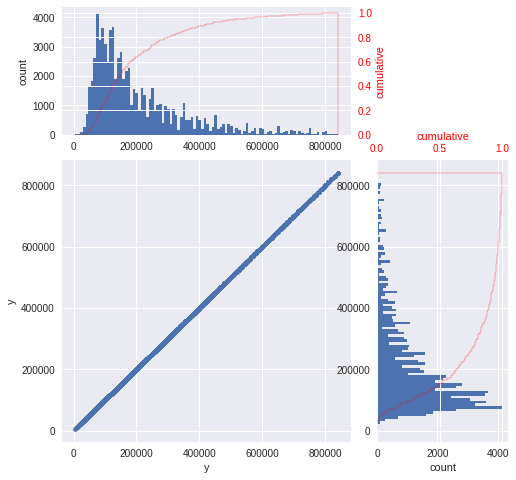

In [144]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

xpl = y
ypl = y

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

ax_main.scatter(xpl,ypl,marker='.')
ax_main.set(xlabel="y", ylabel="y")

ax_xDist.hist(xpl,bins=100,align='mid')
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(xpl,bins=100,cumulative=True,histtype='step',normed=True,color='r',align='mid')
ax_xCumDist.tick_params('y', colors='r')
ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(ypl,bins=100,orientation='horizontal',align='mid')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(ypl,bins=100,cumulative=True,histtype='step',normed=True,color='r',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='r')
ax_yCumDist.set_xlabel('cumulative',color='r')

plt.show()

### 2.b) Split (separación en train/test)

Por ser un problema supervisado, se separa la muestra en dos partes:

*   Train (70%)  - Entrenamiento del modelo
*   Test  (30%)  -  Verificación de rendimiento



In [145]:
#Separamos el dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#Guardamos un indicador en el dfModelo si es usado para Train o Test
indices_train=np.array(y_train.index)
dfM.loc[indices_train,'train']=True
dfM['train'].fillna(False, inplace=True)

(53127, 525) (53127,)
(22769, 525) (22769,)


### 2.c) Train

Se estandarizan los datos y se conservan los parámetros de transformación aplicados (son estos mismos los que deben aplicarse sobre el grupo test para analizar el rendimiento).

Se transforman las variables para que tengan media 0 $(\mu = 0)$ y desvío estándar 1 $(\sigma = 1)$, aplicando la fórmula:

$$ x' = \frac{x - \mu}{\sigma}$$

In [0]:
StdSclr  = StandardScaler()
X_train = StdSclr.fit_transform(X_train)

**CV - Cross Validation**

El entrenamiento de los modelos se hará aplicando Validación Cruzada (CV). Esto quiere decir que:

1. Se separa el grupo train en n partes
2. Para cada modelo y alfa (= 1/ lambda), se determinan los mejores valores betas como predictores
3. De cada subgrupo CV, se calcula el R² con los alfas obtenidos
4. Para el lambda dado, se toma el promedio de los Ri² de los n grupos como representativo
5. Se busca el lambda con mejor rendimiento



In [0]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

if predecir == 'y_price_usd':                 # predecir = 'y_price_usd'
  al_ridge = np.linspace(8000, 8500, 50, endpoint=True)
  al_lasso = np.linspace(1150, 1350, 50, endpoint=True)
  al_enet =  np.linspace(0.1, 100, 50, endpoint=True)
  l1_enet =  [0.01, 0.1, 1, 10, 100, 1000, 10000]

else:                                        # predecir = 'y_price_m2_usd'
  al_ridge = np.linspace(3000, 4000, 50)
  al_lasso = np.linspace(5000, 10000, 100)
  al_enet  = np.linspace(5000, 10000, 100)
  l1_enet  = [0.01, 0.1, 1, 10, 100, 1000, 10000]
  
#   al_ridge = np.geomspace(800, 1200, 20, endpoint=True)
#   al_lasso = np.geomspace(400, 800, 20, endpoint=True)
#   al_enet =  np.geomspace(0.1, 100, 20, endpoint=True)
#   l1_enet =  0.7


kf = KFold(n_splits=5, shuffle=True, random_state=8)

# Instanciamos los modelos
lm        = LinearRegression()
lmRidgeCV = RidgeCV(alphas=al_ridge,cv=kf, normalize=False)
lmLassoCV = LassoCV(alphas=al_lasso, cv=kf, normalize=False,tol=0.01)
lmENetCV  = ElasticNetCV(alphas=al_enet, l1_ratio = l1_enet,cv=kf, normalize=False)

**Entrenamiento de los modelos**

Se entrena cada uno de los modelos instanciados previamente, empleando los valores de alfa indicados y los grupos de CV establecidos.

In [148]:
lm.fit(X_train, y_train,)
lmRidgeCV.fit(X_train, y_train)
lmLassoCV.fit(X_train, y_train)
lmENetCV.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:1032: RuntimeWarning: overflow encountered in square
  this_mses = ((residues ** 2).mean(axis=0)).mean(axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=array([  0.1    ,   2.13878,   4.17755,   6.21633,   8.2551 ,  10.29388,
        12.33265,  14.37143,  16.4102 ,  18.44898,  20.48776,  22.52653,
        24.56531,  26.60408,  28.64286,  30.68163,  32.72041,  34.75918,
        36.79796,  38.83673,  40.87551,  42.91429,  44.95306,  46.99184,
 ...      85.72857,  87.76735,  89.80612,  91.8449 ,  93.88367,  95.92245,
        97.96122, 100.     ]),
       copy_X=True, cv=KFold(n_splits=5, random_state=8, shuffle=True),
       eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 1, 10, 100, 1000, 10000], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

Para cada modelo, se determina:

*   Alfa con mejor rendimiento
*   R² del modelo para el alfa dado
*   ECM (Error Cuadrático Medio)

A modo de referencia, para la elección del modelo a emplear, se calcula un límite inferior de R² como el máximo menos 1 desvío.



In [149]:
# Imprimimos el alfa de cada modelo

print('Alpha Ridge:  ',lmRidgeCV.alpha_,'\n'
      'Alpha LASSO:  ',lmLassoCV.alpha_,'\n'
      'Alpha El.Net: ',lmENetCV.alpha_,'\n')


# Calculamos el R2

print("\n",
      "Score Train Lineal:   ", round(lm.score(X_train, y_train),4),"\n",
      "Score Train Ridge:    ", round(lmRidgeCV.score(X_train, y_train),4),"\n",
      "Score Train Lasso:    ", round(lmLassoCV.score(X_train, y_train),4),"\n",
      "Score Train El. Net:  ", round(lmENetCV.score(X_train, y_train),4),"\n")


# Determinamos el valor límite recomendado para la elección del modelo

scores=[lm.score(X_train, y_train),
        lmRidgeCV.score(X_train, y_train),
        lmLassoCV.score(X_train, y_train),
        lmENetCV.score(X_train, y_train)]
scores_std=np.std(np.array(scores))
scores_limite= np.max(scores)-scores_std

print("(MáxScore - 1desvío):  ",round(scores_limite,4),'\n'*2)

  
#Predecimos los valores de Y a partir de X_train

lmpred_Tr =       lm.predict(X_train)
lmRidgepred_Tr =  lmRidgeCV.predict(X_train)
lmLassoepred_Tr = lmLassoCV.predict(X_train)
lmENet_Tr=        lmENetCV.predict(X_train)


# Calculamos el MSE

print("Train MSE lineal:    ", round(mean_squared_error(y_train,lmpred_Tr),2), "\n"
      "Train MSE Ridge:     ", round(mean_squared_error(y_train,lmRidgepred_Tr),2), "\n"
      "Train MSE Lasso:     ", round(mean_squared_error(y_train,lmLassoepred_Tr),2), "\n"
      "Train MSE El. Net:   ", round(mean_squared_error(y_train,lmENet_Tr),2))

Alpha Ridge:   8285.714285714286 
Alpha LASSO:   1337.7551020408164 
Alpha El.Net:  0.1 


 Score Train Lineal:    0.7071 
 Score Train Ridge:     0.6443 
 Score Train Lasso:     0.6412 
 Score Train El. Net:   0.652 

(MáxScore - 1desvío):   0.6803 


Train MSE lineal:     6650987074.76 
Train MSE Ridge:      8075980273.84 
Train MSE Lasso:      8145646008.5 
Train MSE El. Net:    7901073950.63


**Cálculo de predicciones y coeficientes**

Se incorporan al dfM los campos predichos por cada modelo.
Además, se establecen series correspondientes a cada tipo de propiedad e indicadores para Train/Test


In [0]:
#Transformación de X (train y test) según la estandarización realizada para Xtest
X_N = StdSclr.transform(X,)

#Predicciones de y para los modelos entrenados
dfM['y_pred_lineal'] = lm.predict(X_N)
dfM['y_pred_ridge']  = lmRidgeCV.predict(X_N)
dfM['y_pred_lasso']  = lmLassoCV.predict(X_N)
dfM['y_pred_enet']   = lmENetCV.predict(X_N)

#Indicadores de tipo de propiedad
f_ap = (dfM['tipo_apartment']==True)
f_ho = (dfM['tipo_house']==True)
f_st = (dfM['tipo_store']==True)
f_ph = ~(f_ap|f_ho|f_st)

#Indicadores de Train/Test
f_tr = (dfM['train']==True)
f_te = ~f_tr

Se obtienen los ponderadores (coeficientes) de cada uno de los features (xi) de X.

In [151]:
#Coeficientes para cada feature
c_lineal = pd.DataFrame(list(lm.coef_),index=list(X.columns),columns=['lineal'])
c_ridge  = pd.DataFrame(list(lmRidgeCV.coef_),index=list(X.columns),columns=['ridge'])
c_lasso  = pd.DataFrame(list(lmLassoCV.coef_),index=list(X.columns),columns=['lasso'])
c_enet   = pd.DataFrame(list(lmENetCV.coef_),index=list(X.columns),columns=['enet'])

coeficientes=pd.concat([c_lineal[:],c_ridge[:],c_lasso[:],c_enet[:]],axis=1)

del [c_lineal,c_ridge,c_lasso,c_enet]

coeficientes.head()

,lineal,ridge,lasso,enet
1,-1.478007e+06,0.000000,0.000000,0.000000
stot,-1.274848e+16,-738.614590,0.000000,-122.007693
scub,7.154779e+07,7289.077037,26387.280964,8713.283728
rooms,2.247286e+07,4710.549323,4879.163844,4655.130123
floor,5.760200e+08,-2414.808026,-0.000000,-3007.294299


**Gráficos de análisis**

Previamente a decidir qué modelo adoptar, se visualiza el ajuste de la prediccón respecto a los datos originales.
Se observa asi para cada modelo cuánto se apartan los valores obtenidos respecto al original.

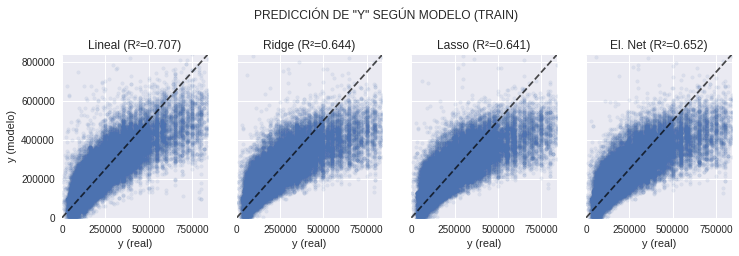

In [152]:
d = {'Lineal':     [lmpred_Tr,
                   round(lm.score(X_train, y_train),3)],
    'Ridge':       [lmRidgepred_Tr,
                   round(lmRidgeCV.score(X_train, y_train),3)],
    'Lasso':       [lmLassoepred_Tr,
                   round(lmLassoCV.score(X_train, y_train),3)],
    'El. Net':     [lmENet_Tr,
                   round(lmENetCV.score(X_train, y_train),3)]}

#xmin=min(y_train)
#ymin=min(y_train)
xmin = 0
xmax = max(y_train)
ymin = 0
ymax = max(y_train)

plt.figure(figsize=[12,3])
plt.suptitle('PREDICCIÓN DE "Y" SEGÚN MODELO (TRAIN)',y=1.1)

n = 1
for key in d:
  plt.subplot(140+n)
  plt.title(key+' (R²='+str(d[key][1])+')')
  plt.xlabel('y (real)')
  plt.scatter(y_train, d[key][0], marker=".", alpha=0.1)
  plt.plot([xmin, xmax],[ymin,ymax],color='k',linestyle ='--',alpha=0.7)
  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])
  if n==1:
    plt.ylabel('y (modelo)')
  else:
    axes.yaxis.set_ticklabels([])
  n+=1
  
del [key, n, d]

Idem punto anterior, pero discriminando según tipo de propiedad.

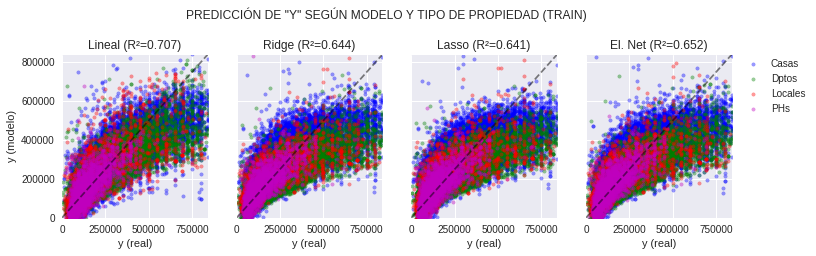

In [153]:
d = {'Lineal':     ['y_pred_lineal',
                   round(lm.score(X_train, y_train),3)],
    'Ridge':       ['y_pred_ridge',
                   round(lmRidgeCV.score(X_train, y_train),3)],
    'Lasso':       ['y_pred_lasso',
                   round(lmLassoCV.score(X_train, y_train),3)],
    'El. Net':     ['y_pred_enet',
                   round(lmENetCV.score(X_train, y_train),3)]}



#xmin=min(y_train)
#ymin=min(y_train)
xmin = 0
xmax = max(y_train)
ymin = 0
ymax = max(y_train)

plt.figure(figsize=[12,3])
plt.suptitle('PREDICCIÓN DE "Y" SEGÚN MODELO Y TIPO DE PROPIEDAD (TRAIN)',y=1.1)

n = 1
for key in d:
  plt.subplot(140+n)
  plt.title(key+' (R²='+str(d[key][1])+')')
  plt.xlabel('y (real)')

  plt.scatter(dfM.loc[f_tr&f_ho,'y_price_usd'], dfM.loc[f_tr&f_ho,str(d[key][0])],
              marker=".", c='b', alpha=0.4, label='Casas')
  plt.scatter(dfM.loc[f_tr&f_ap,'y'], dfM.loc[f_tr&f_ap,str(d[key][0])],
              marker=".", c='g', alpha=0.4, label='Dptos')
  plt.scatter(dfM.loc[f_tr&f_st,'y'], dfM.loc[f_tr&f_st,str(d[key][0])],
              marker=".", c='r', alpha=0.4, label='Locales')
  plt.scatter(dfM.loc[f_tr&f_ph,'y'], dfM.loc[f_tr&f_ph,str(d[key][0])],
              marker=".", c='m', alpha=0.4, label='PHs')
    
  plt.plot([xmin, xmax],[ymin,ymax],color='k',linestyle ='--',alpha=0.5)
  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])
  if n==1:
    plt.ylabel('y (modelo)')
  else:
    axes.yaxis.set_ticklabels([])
  n+=1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
del [key, n, d]

Se grafican los coeficientes de mayor peso para establecer cuáles son los features de mayor importancia.
Para esto, se considerann los diez mayores y los diez menores.

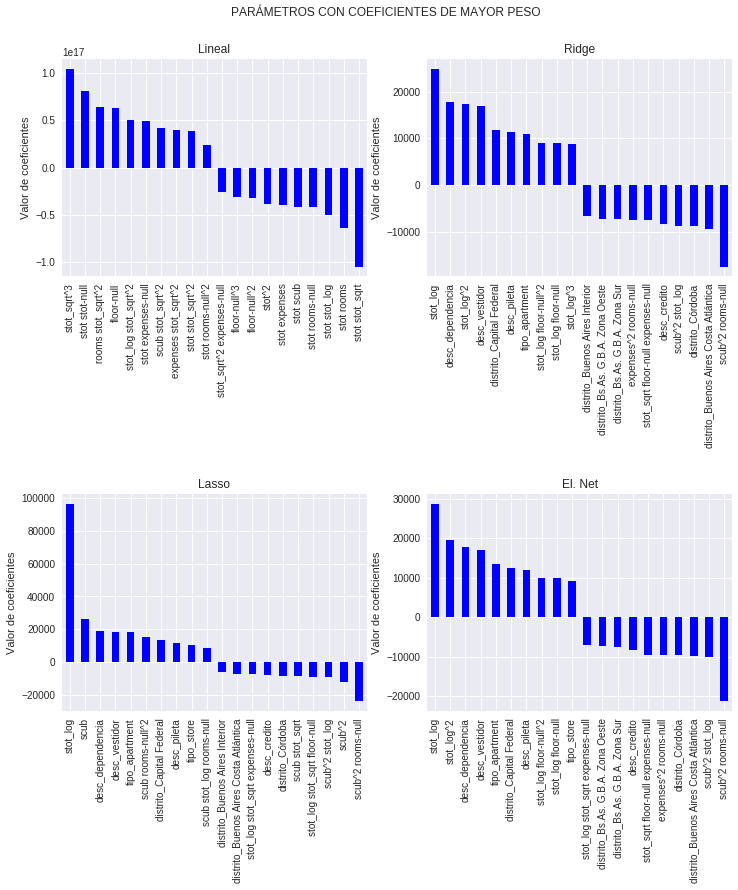

In [165]:
d = {'lineal': 'Lineal',
     'ridge': 'Ridge',
     'lasso': 'Lasso',
     'enet': 'El. Net'}


plt.figure(figsize=[12,12])
plt.suptitle('PARÁMETROS CON COEFICIENTES DE MAYOR PESO',y=0.94)

n = 1
for x in d:
  a=pd.concat([coeficientes[x].sort_values(ascending=False).head(10),
           coeficientes[x].sort_values(ascending=False).tail(10)],
          axis=0)
  
  plt.subplot(220+n)
  plt.title(d[x])
  plt.subplots_adjust(hspace = 1)
  a.plot(kind = 'bar',color='b')
  plt.ylabel('Valor de coeficientes')
  n+=1

del [x,a,n,d]

Por último, se genera un histograma de frecuencias de los valores de los coeficientes, apreciando así cómo es la distribución segun cada tipo de modelo. Como aclaración, se observa claramente cómo Lasso elimina variables mientras que Ridge las reduce proporcionalmente.

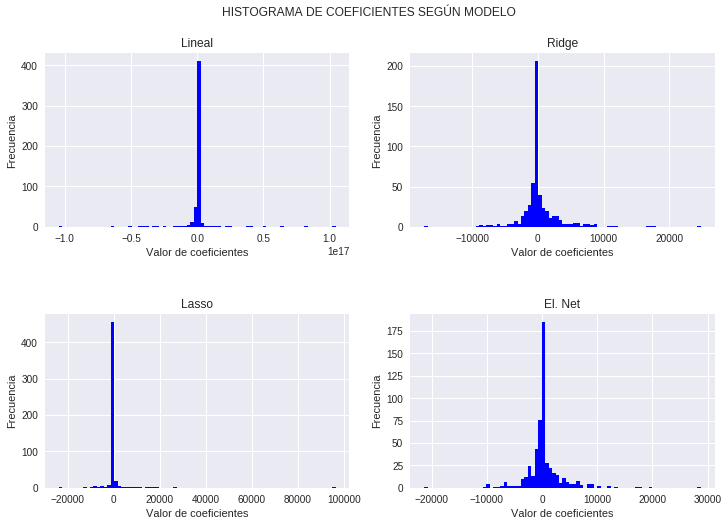

In [166]:
d = {'lineal': 'Lineal',
     'ridge': 'Ridge',
     'lasso': 'Lasso',
     'enet': 'El. Net'}



plt.figure(figsize=[12,8])
plt.suptitle('HISTOGRAMA DE COEFICIENTES SEGÚN MODELO',y=0.96)

n = 1
for x in d:
  plt.subplot(220+n)
  plt.subplots_adjust(hspace = .5)
  plt.title(d[x])
  plt.hist(coeficientes[x],color='b',bins=80)
  plt.ylabel('Frecuencia')
  plt.xlabel('Valor de coeficientes')
  n+=1

del [x,n]

In [0]:
# (lm.intercept_,lm.coef_)
# (lmRidgeCV.intercept_,lmRidgeCV.coef_)
# (lmLassoCV.intercept_,lmLassoCV.coef_)
# (lmENetCV.intercept_,lmENetCV.coef_)

**CONCLUSIÓN**

Se elije LASSO por ser un modelo más simple y obtener un R² de referencia (R²max-1desvío)

In [157]:
lst_md = ['Lineal','Ridge','Lasso','El. Net']

m = lst_md[2]
m


'Lasso'

Ya elegido el modelo, se centra la atención en los resultados de éste  y se incorporan tambien los demás modelos sólo con fines exploratorios.

### 2.d) Test

Se normalizan los valores de X_test con los mismos parámetros que los obtenidos para X_train.
Luego, se determina el puntaje R² para el grupo train y se calcula el ECM.

In [158]:
#Normalización de X_test según la transformación de Xtrain
X_testN = StdSclr.transform(X_test,)

print(
      "Score Test Lineal:   ", round(lm.score(X_testN, y_test),4),"\n"
      "Score Test Ridge:    ", round(lmRidgeCV.score(X_testN, y_test),4),"\n"
      "Score Test Lasso:    ", round(lmLassoCV.score(X_testN, y_test),4),"\n"
      "Score Test El. Net:  ", round(lmENetCV.score(X_testN, y_test),4),"\n"
      )


# Hacemos las predicciones sobre la matriz de predictores del Test Set

lmpred_Te       = lm.predict(X_testN)
lmRidgepred_Te  = lmRidgeCV.predict(X_testN)
lmLassoepred_Te = lmLassoCV.predict(X_testN)
lmENet_Te       = lmENetCV.predict(X_testN)

# Testeo final del modelo sobre Test Set

print(
      "Train MSE lineal:    ", round(mean_squared_error(y_test,lmpred_Te),2), "\n"
      "Train MSE Ridge:     ", round(mean_squared_error(y_test,lmRidgepred_Te),2), "\n"
      "Train MSE Lasso:     ", round(mean_squared_error(y_test,lmLassoepred_Te),2), "\n"
      "Train MSE El. Net:   ", round(mean_squared_error(y_test,lmENet_Te),2),
      )

Score Test Lineal:    -13395.2244 
Score Test Ridge:     0.6282 
Score Test Lasso:     0.6275 
Score Test El. Net:   0.6312 

Train MSE lineal:     304977556609519.06 
Train MSE Ridge:      8463294626.5 
Train MSE Lasso:      8481122600.61 
Train MSE El. Net:    8397131770.74


Se visualizan los resultados para observar el comportamiento del modelo para diferentes valores de y.

Como se menciono anteriormente, los resultados para los otros modelos se muestran sólo a fines exploratorios.

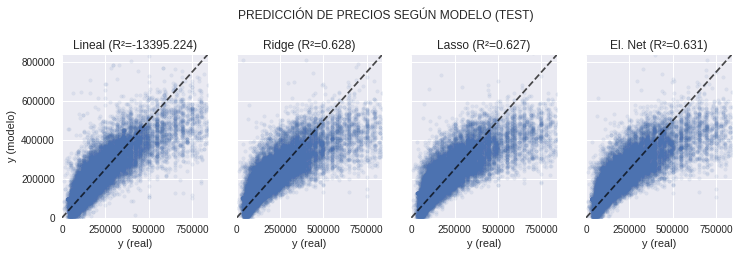

In [159]:
d = {'Lineal':     [lmpred_Te,
                   round(lm.score(X_testN, y_test),3)],
    'Ridge':       [lmRidgepred_Te,
                   round(lmRidgeCV.score(X_testN, y_test),3)],
    'Lasso':       [lmLassoepred_Te,
                   round(lmLassoCV.score(X_testN, y_test),3)],
    'El. Net':     [lmENet_Te,
                   round(lmENetCV.score(X_testN, y_test),3)]}

#xmin = min(y_train)
#ymin = min(y_train)
xmin = 0
xmax = max(y_test)
ymin = 0
ymax = max(y_test)

plt.figure(figsize=[12,3])
plt.suptitle('PREDICCIÓN DE PRECIOS SEGÚN MODELO (TEST)',y=1.1)

n = 1
for key in d:
  plt.subplot(140+n)
  plt.title(key+' (R²='+str(d[key][1])+')')
  plt.xlabel('y (real)')
  plt.scatter(y_test, d[key][0], marker=".", alpha=0.1)
  plt.plot([xmin, xmax],[ymin,ymax],color='k',linestyle ='--',alpha=0.7)
  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])
  if n==1:
    plt.ylabel('y (modelo)')
  else:
    axes.yaxis.set_ticklabels([])
  n+=1
  
del [key, n, d]

Se visualizan los resultados para el modelo seleccionado, identificando los valores empleados para train y los utlizados para test.

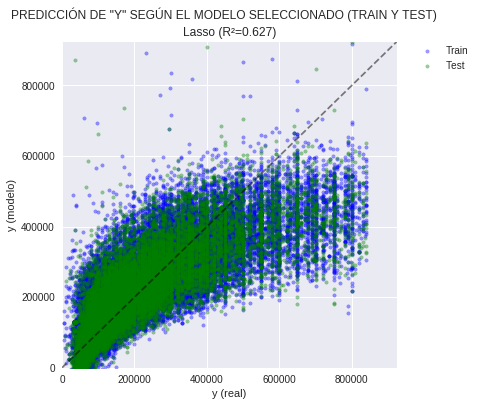

In [160]:
d = {'Lineal':     ['y_pred_lineal',
                   round(lm.score(X_testN, y_test),3)],
    'Ridge':       ['y_pred_ridge',
                   round(lmRidgeCV.score(X_testN, y_test),3)],
    'Lasso':       ['y_pred_lasso',
                   round(lmLassoCV.score(X_testN, y_test),3)],
    'El. Net':     ['y_pred_enet',
                   round(lmENetCV.score(X_testN, y_test),3)]}


#xmin=min(y_train)
#ymin=min(y_train)
xmin = 0
xmax = max(dfM['y'])*1.1
ymin = 0
ymax = max(dfM['y'])*1.1

plt.figure(figsize=[6,6])
plt.suptitle('PREDICCIÓN DE "Y" SEGÚN EL MODELO SELECCIONADO (TRAIN Y TEST)',y=0.96)

plt.plot(121)
plt.title(m+' (R²='+str(d[m][1])+')')
plt.xlabel('y (real)')
plt.scatter(dfM.loc[f_tr,'y'], dfM.loc[f_tr,d[m][0]],
            marker=".", c='b', alpha=0.4, label='Train')
plt.scatter(dfM.loc[f_te,'y'], dfM.loc[f_te,d[m][0]],
            marker=".", c='g', alpha=0.4, label='Test')
plt.plot([xmin, xmax],[ymin,ymax],color='k',linestyle ='--',alpha=0.5)
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.ylabel('y (modelo)')
  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
del [d]

Por últomo, se hace lo mismo discriminando los diferentes tipos de propiedad.

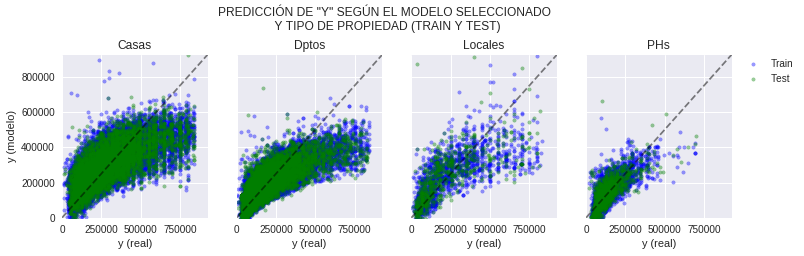

In [161]:
d = {'Lineal':     ['y_pred_lineal'],
    'Ridge':       ['y_pred_ridge'],
    'Lasso':       ['y_pred_lasso'],
    'El. Net':     ['y_pred_enet']}

cl = {'Casas':   [f_ho],
     'Dptos':    [f_ap],
     'Locales':  [f_st],
     'PHs':      [f_ph]}


#xmin=min(y_train)
#ymin=min(y_train)
xmin = 0
xmax = max(dfM['y'])*1.1
ymin = 0
ymax = max(dfM['y'])*1.1

plt.figure(figsize=[12,3])
plt.suptitle('PREDICCIÓN DE "Y" SEGÚN EL MODELO SELECCIONADO \n Y TIPO DE PROPIEDAD (TRAIN Y TEST)',y=1.1)

n = 1
for key in cl:
  pl_k = key
  pl_f = cl[key][0]
  
  plt.subplot(140+n)
  plt.title(key)
  plt.xlabel('y (real)')
  
  plt.scatter(dfM.loc[f_tr&pl_f,'y'],
              dfM.loc[f_tr&pl_f,d[m][0]],
              marker=".",
              c='b',
              alpha=0.4,
              label='Train')
  
  plt.scatter(dfM.loc[f_te&pl_f,'y'],
              dfM.loc[f_te&pl_f,d[m][0]],
              marker=".",
              c='g',
              alpha=0.4,
              label='Test')
  
  plt.plot([xmin, xmax],[ymin,ymax],color='k',linestyle ='--',alpha=0.5)
  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])
  if n==1:
    plt.ylabel('y (modelo)')
  else:
    axes.yaxis.set_ticklabels([])
  n+=1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
del [key, n, d, cl, pl_k, pl_f]

## 3.Portfolio de propiedades

Se plantea como ejercicio la tenencia de un protfolio de n propiedades. Se pregunta entonces cuáles uno debería vender y cuáles debería conservar.

### 3.a) Inicialización del portfolio

Se inicializa el portfolio con una muestra de n propiedades o bien, todo el dataset completo.

A modo de aclaración se observa que previamente a esta paso deberían haberse descartado aquellas propiedades para las que el modelo realiza predicciones erróneas a partir de cierto criterio.

In [0]:
# muestra: cantidad de propiedades a seleccionar de manera aleatoria
#          0: considera todo el dataframe

muestra = 50

if muestra==0:
  dfP = dfM
else:
  dfP = dfM.sample(n=muestra, random_state=30)

Se crea como campo auxiliar una funcion de retorno, dada por la diferencia relativa entre el valor predicho por el modelo y el valor real.

A los fines del ejercicio, no se considera costo de operación, por lo que se plantea como solución "vender" todas las propiedades y luego "comprar" aquellas que convienen.

In [210]:
d = {'Lineal':     ['y_pred_lineal'],
    'Ridge':       ['y_pred_ridge'],
    'Lasso':       ['y_pred_lasso'],
    'El. Net':     ['y_pred_enet']}


def portfolio_init( df         = dfP,
                    precio     = 'y_price_usd',
                    precio_Mod = d[m][0]):
  
  if predecir == 'y_price_usd':
    df['y_price_Mod']  = df[precio_Mod] * 1
  else:
    df['y_price_Mod']  = df[precio_Mod] * df['stot']

  df['ret_abs']      =   df['y_price_Mod'] - df[precio]
  df['ret_porc']     = ( df['y_price_Mod'] - df[precio] ) / df[precio]
  df['comprar']      = False
  
  df = df.sort_values(by='ret_porc',ascending=False)
  
  return print('Presupuesto: ',str(sum( dfP['y_price_usd'] )))

portfolio_init()

Presupuesto:  9204910.0


In [211]:
dfP[['y_price_usd','y_pred_lasso','ret_abs','ret_porc','comprar']]

,y_price_usd,y_pred_lasso,ret_abs,ret_porc,comprar
4864,395000.0,271533.744453,-123466.255547,-0.312573,False
71732,304557.0,176087.361047,-128469.638953,-0.421825,False
37673,345000.0,293759.299251,-51240.700749,-0.148524,False
56631,148961.0,145411.741615,-3549.258385,-0.023827,False
57397,96592.0,150822.682513,54230.682513,0.561441,False
39313,175000.0,194304.445234,19304.445234,0.110311,False
38574,275000.0,229060.002364,-45939.997636,-0.167055,False
35088,425000.0,393263.891191,-31736.108809,-0.074673,False
25285,178000.0,189728.057050,11728.057050,0.065888,False
30216,90000.0,133884.962537,43884.962537,0.487611,False


In [212]:
dfP.sort_values('ret_porc',ascending=False)[['y_price_usd','y_pred_lasso','ret_abs','ret_porc','comprar']]

,y_price_usd,y_pred_lasso,ret_abs,ret_porc,comprar
14548,20000.0,65110.314071,45110.314071,2.255516,False
66925,70000.0,136673.557863,66673.557863,0.952479,False
33769,110000.0,214195.358350,104195.358350,0.947231,False
20676,165000.0,318580.649535,153580.649535,0.930792,False
22613,130000.0,212843.767619,82843.767619,0.637260,False
21411,160000.0,254274.089351,94274.089351,0.589213,False
9080,150000.0,235097.964099,85097.964099,0.567320,False
57397,96592.0,150822.682513,54230.682513,0.561441,False
30216,90000.0,133884.962537,43884.962537,0.487611,False
56615,56000.0,82898.806968,26898.806968,0.480336,False


### 3.b) Propiedades a vender/conservar

Dada la restricción establecida por el presupuesto que se tiene (suma de todas las propiedades del protfolio), se busca maximizar el beneficio dado por la suma de todos los retornos positivos.

In [0]:
lst_vals = list(dfP.sort_values(by='ret_porc',ascending=False).index)

presupuesto = sum( dfP['y_price_usd'] )
saldo       = 0
beneficio   = 0


for x in lst_vals:
  
  precio_i    = dfP.loc[x,'y_price_usd']
  beneficio_i = dfP.loc[x,'ret_porc']
    
  if (presupuesto - saldo > precio_i) & (beneficio_i>0) :
    dfP.loc[x,'comprar'] = True
    saldo     += precio_i
    beneficio += beneficio_i
    
  else:
    break

In [214]:
dfP.sort_values('ret_porc',ascending=False)[['y_price_usd','y_pred_lasso','ret_abs','ret_porc','comprar']]

,y_price_usd,y_pred_lasso,ret_abs,ret_porc,comprar
14548,20000.0,65110.314071,45110.314071,2.255516,True
66925,70000.0,136673.557863,66673.557863,0.952479,True
33769,110000.0,214195.358350,104195.358350,0.947231,True
20676,165000.0,318580.649535,153580.649535,0.930792,True
22613,130000.0,212843.767619,82843.767619,0.637260,True
21411,160000.0,254274.089351,94274.089351,0.589213,True
9080,150000.0,235097.964099,85097.964099,0.567320,True
57397,96592.0,150822.682513,54230.682513,0.561441,True
30216,90000.0,133884.962537,43884.962537,0.487611,True
56615,56000.0,82898.806968,26898.806968,0.480336,True


### 3.c) Resumen de resultados

Como resultado, se obtienen las propiedades a vender/conservar para maximizar el beneficio.

In [215]:
c = sum(dfP['comprar'])
v = sum(~dfP['comprar'])
b = round(sum(dfP.loc[dfP['comprar'],'ret_porc']),2)

print('RESUMEN DE OPERACIONES:', '\n',
      '\t','A conservar: ','\t', str(c), 'propiedades\n',
      '\t','A vender: ','\t', str(v), 'propiedades \n\n',
      'BENEFICIO OBTENIDO:', '\n',
      '\t',str(round(b*100,2)),'%'
     )

del [c,v,b]

RESUMEN DE OPERACIONES: 
 	 A conservar:  	 31 propiedades
 	 A vender:  	 19 propiedades 

 BENEFICIO OBTENIDO: 
 	 1212.0 %
